# Xử lý dữ liệu bước đầu


KHÔNG BẤM "RUN ALL"

thứ tự chạy: 

1/ import (BẮT BUỘC)

2/ Cell 1 Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)

	Cell 2 đến cell 9 để hoàn tất quá trình lấy dữ liệu

   (quay lại cell 1 để đổi tên r chạy tiếp cho đủ 5 đồng coin)

qua phần Tổng hợp dữ liệu

SYMBOL_BASE =  (chỉnh giống cell 1 ở trên)

	chạy cell 10 (xong quay lại chỉnh SYMBOL_BASE)


qua phần Gộp các dữ liệu lại.

	tới đây chạy từ từ cho in ra từng cái là được 
	

## import

In [9]:
import os, time, math, random, requests
import pandas as pd
from datetime import datetime, timezone, timedelta
from tqdm import tqdm
from pytrends.request import TrendReq
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Lấy file dữ liệu


1) Khung dữ liệu cần các cột mục tiêu:
- Date, Open, High, Low, Close, Volume, symbol
- Quote_Volume, Number_Of_Trades
- funding_Rate
- fetch_fear_greed
- active_addresses, hash_rate, tx_count, miners_revenue
time_frame

In [ ]:
# Cell 1️⃣: Import & cấu hình cơ bản (phiên bản cố định, không cần nhập)
# -----------------------
# CONFIG CỐ ĐỊNH
# -----------------------

# Dữ liệu coin bạn muốn lấy
SYMBOL_BASE = "BTC"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"
SYMBOL_BINANCE = SYMBOL_BASE + "USDT"   # tự tạo mã Binance Futures

# Thông tin thời gian
INTERVAL = "1d"                 # khung thời gian: "1d", "1h", ...
START_DATE = "2023-01-01"       # ngày bắt đầu
END_DATE = "2025-08-01"         # ngày kết thúc

# Thư mục lưu dữ liệu
OUT_DIR = os.path.join("data", SYMBOL_BASE)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"✅ Đang lấy dữ liệu cho {SYMBOL_BASE} ({SYMBOL_BINANCE}) từ {START_DATE} → {END_DATE}, interval={INTERVAL}")

✅ Đang lấy dữ liệu cho XRP (XRPUSDT) từ 2023-01-01 → 2025-08-01, interval=1d


In [62]:
# Cell 2️⃣: Hàm xử lý thời gian (convert timestamp <-> datetime)

def dt_to_millis(dt: datetime):
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def date_to_millis(s):
    dt = datetime.fromisoformat(s)
    return dt_to_millis(dt)

def millis_to_date(millis):
    return datetime.fromtimestamp(millis/1000, tz=timezone.utc).date()


In [63]:
def fetch_binance_klines(symbol, interval, start_ts_ms, end_ts_ms):
    """
    Lấy dữ liệu OHLC từ Binance Futures (fallback sang Spot nếu bị chặn 418)
    """
    futures_url = "https://fapi.binance.com/fapi/v1/klines"
    spot_url = "https://api.binance.com/api/v3/klines"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    limit = 1000
    all_klines = []
    start = start_ts_ms
    use_spot = False

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start,
            "endTime": end_ts_ms,
            "limit": limit
        }

        # chọn API phù hợp
        url = spot_url if use_spot else futures_url
        try:
            r = requests.get(url, params=params, headers=headers, timeout=30)
            if r.status_code == 418:
                print(f"[WARN] Binance Futures chặn IP (418) → chuyển sang Spot API.")
                use_spot = True
                continue
            r.raise_for_status()
            data = r.json()
        except requests.exceptions.HTTPError as e:
            print(f"[ERROR] {e}")
            break
        except Exception as e:
            print(f"[WARN] Network error: {e}")
            time.sleep(5)
            continue

        if not data:
            break

        all_klines.extend(data)
        if len(data) < limit:
            break
        last_open = data[-1][0]
        start = last_open + 1
        time.sleep(0.2)

    # Chuyển sang DataFrame
    if not all_klines:
        print("[WARN] Không lấy được dữ liệu Klines.")
        return pd.DataFrame(columns=["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades","symbol"])

    cols = ["open_time","open","high","low","close","volume","close_time",
            "quote_asset_volume","num_trades","taker_buy_base_vol","taker_buy_quote_vol","ignore"]

    df = pd.DataFrame(all_klines, columns=cols)
    df["Date"] = pd.to_datetime(df["open_time"], unit="ms", utc=True).dt.date
    df = df[["Date","open","high","low","close","volume","quote_asset_volume","num_trades"]]
    df.columns = ["Date","Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]
    for c in ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["symbol"] = SYMBOL_BASE
    df = df.sort_values("Date").drop_duplicates("Date").reset_index(drop=True)

    print(f"✅ Dữ liệu Binance ({'Spot' if use_spot else 'Futures'}) tải thành công: {len(df)} dòng")
    return df


In [64]:
# Cell 4️⃣: Funding Rate trung bình theo ngày (Binance Futures)

def fetch_binance_funding(symbol, start_ts_ms, end_ts_ms):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_rows = []
    start = start_ts_ms

    while True:
        params = {"symbol": symbol, "startTime": start, "endTime": end_ts_ms, "limit": limit}
        r = requests.get(url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        if not data:
            break

        all_rows.extend(data)
        if len(data) < limit:
            break

        last_t = data[-1]["fundingTime"]
        start = last_t + 1
        time.sleep(0.2)

    if not all_rows:
        return pd.DataFrame(columns=["Date","funding_Rate"])

    df = pd.DataFrame(all_rows)
    df["fundingTime"] = pd.to_datetime(df["fundingTime"], unit="ms", utc=True)
    df["Date"] = df["fundingTime"].dt.date
    df["fundingRate"] = pd.to_numeric(df["fundingRate"], errors="coerce")
    daily = df.groupby("Date", as_index=False)["fundingRate"].mean().rename(columns={"fundingRate":"funding_Rate"})
    return daily

In [65]:
# Cell 5️⃣: Lấy Fear & Greed Index (Alternative.me API) — phiên bản ổn định nhất

def fetch_fear_greed(limit=0):
    """
    Lấy dữ liệu Fear & Greed Index từ API alternative.me
    Trả về DataFrame có cột: Date, fetch_fear_greed
    """
    url = "https://api.alternative.me/fng/"
    params = {"limit": limit, "format": "json"}  # không dùng date_format vì không cần thiết

    try:
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        j = r.json()
        data = j.get("data", [])
    except Exception as e:
        print(f"[WARN] Fear & Greed API failed: {e}")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    # Nếu rỗng, in cảnh báo
    if not data:
        print("[WARN] Fear & Greed API returned empty dataset, skipping...")
        return pd.DataFrame(columns=["Date", "fetch_fear_greed"])

    rows = []
    for entry in data:
        try:
            ts = int(entry["timestamp"])
            value = float(entry["value"])
            date = datetime.fromtimestamp(ts, tz=timezone.utc).date()
            rows.append({"Date": date, "fetch_fear_greed": value})
        except Exception as e:
            print(f"[WARN] parse error: {e}")
            continue

    df = pd.DataFrame(rows)
    df = df.drop_duplicates("Date").sort_values("Date").reset_index(drop=True)
    print(f"✅ Fear & Greed fetched: {len(df)} rows")
    print(df.head())
    return df

In [66]:
# Cell 6️⃣: On-chain metrics (active_addresses, hash_rate, tx_count, miners_revenue)

BLOCKCHAIN_CHARTS = {
    # "active_addresses": "n-active-addresses",  # ⚠️ gỡ bỏ vì bị 404
    "hash_rate": "hash-rate",
    "tx_count": "n-transactions",
    "miners_revenue": "miners-revenue"
}


def fetch_blockchain_chart(chart_name, timespan_days=4000):
    url = f"https://api.blockchain.info/charts/{chart_name}"
    params = {"timespan": f"{timespan_days}days", "format":"json", "sampled":False}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        r = requests.get(url, params={"timespan":f"{timespan_days}days","format":"json"}, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Blockchain.info chart {chart_name} returned {r.status_code}")

    j = r.json()
    values = j.get("values", [])
    rows = [{"Date": datetime.fromtimestamp(v["x"], tz=timezone.utc).date(), chart_name: v["y"]} for v in values]
    return pd.DataFrame(rows).drop_duplicates("Date").sort_values("Date").reset_index(drop=True)

def fetch_onchain_from_blockchain_info(mapping):
    dfs = []
    for outcol, chart in mapping.items():
        try:
            dfc = fetch_blockchain_chart(chart, timespan_days=5000)
            dfc = dfc.rename(columns={chart: outcol})
            dfs.append(dfc)
            time.sleep(0.2)
        except Exception as e:
            print(f"[WARN] Could not fetch chart {chart}: {e}")
    if not dfs:
        return pd.DataFrame(columns=["Date"])
    df_merged = dfs[0]
    for d in dfs[1:]:
        df_merged = pd.merge(df_merged, d, on="Date", how="outer")
    return df_merged.sort_values("Date").reset_index(drop=True)

In [67]:
# Cell 6️⃣b: Lấy dữ liệu Google Trends (Interest Over Time) - có delay và fallback

def fetch_google_trend(symbol_base: str, start_date: str, end_date: str):
    """
    Lấy độ quan tâm Google Trends (Interest Over Time)
    Có delay tránh 429, và fallback từ file local nếu API bị chặn.
    """
    kw = symbol_base.lower()
    if kw == "btc": kw = "bitcoin"
    elif kw == "eth": kw = "ethereum"

    local_path = os.path.join("data", symbol_base, f"google_trend_{symbol_base}.csv")

    # Nếu có file cũ thì đọc lại
    if os.path.exists(local_path):
        print(f"📂 Đọc cache Google Trends từ {local_path}")
        df_cached = pd.read_csv(local_path)
        df_cached["Date"] = pd.to_datetime(df_cached["Date"]).dt.date
        return df_cached

    # Nếu chưa có cache -> gọi API
    time.sleep(random.uniform(10, 20))
    pytrends = TrendReq(hl='en-US', tz=0)
    timeframe = f"{start_date} {end_date}"
    try:
        pytrends.build_payload([kw], timeframe=timeframe)
        df_trend = pytrends.interest_over_time()
    except Exception as e:
        print(f"[WARN] Pytrends failed: {e}")
        return pd.DataFrame(columns=["Date", "google_interest"])

    if df_trend.empty:
        print("[WARN] Pytrends returned empty data.")
        return pd.DataFrame(columns=["Date", "google_interest"])

    df_trend = df_trend.reset_index()
    df_trend["Date"] = df_trend["date"].dt.date
    df_trend = df_trend.rename(columns={kw: "google_interest"})
    df_trend = df_trend[["Date", "google_interest"]]

    # Lưu cache
    df_trend.to_csv(local_path, index=False)
    print(f"✅ Lưu cache: {local_path}")
    return df_trend

In [68]:
# Cell 7️⃣ (cập nhật thêm pytrends)

def build_dataset():
    start_ts = date_to_millis(START_DATE)
    end_dt = datetime.fromisoformat(END_DATE)
    end_of_day = datetime(end_dt.year, end_dt.month, end_dt.day, 23, 59, 59, tzinfo=timezone.utc)
    end_ts = int(end_of_day.timestamp() * 1000)

    print("Fetching klines from Binance futures...")
    df_klines = fetch_binance_klines(SYMBOL_BINANCE, INTERVAL, start_ts, end_ts)
    print(f"klines rows: {len(df_klines)}")

    print("Fetching funding rates...")
    df_fund = fetch_binance_funding(SYMBOL_BINANCE, start_ts, end_ts)
    print(f"funding rows: {len(df_fund)}")

    print("Fetching Fear & Greed index...")
    df_fng = fetch_fear_greed(limit=0)
    print(f"fear&greed rows: {len(df_fng)}")

    print("Fetching on-chain metrics...")
    df_onchain = fetch_onchain_from_blockchain_info(BLOCKCHAIN_CHARTS)
    print(f"onchain rows: {len(df_onchain)}")

    # 🔍 Thêm phần Google Trends
    print("Fetching Google Trends interest...")
    df_trend = fetch_google_trend(SYMBOL_BASE, START_DATE, END_DATE)

    # Merge các bảng
    df = df_klines.copy()
    df = pd.merge(df, df_fund, on="Date", how="left")
    df = pd.merge(df, df_fng, on="Date", how="left")
    df = pd.merge(df, df_onchain, on="Date", how="left")
    df = pd.merge(df, df_trend, on="Date", how="left")  # 🔍 thêm dòng này

    # Bổ sung cột thiếu
    for col in ["funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]:
        if col not in df.columns:
            df[col] = pd.NA

    df["time_frame"] = INTERVAL

    # Thứ tự cột cuối cùng
    final_cols = ["Date","Open","High","Low","Close","Volume","symbol",
                  "Quote_Volume","Number_Of_Trades","funding_Rate","fetch_fear_greed",
                  "active_addresses","hash_rate","tx_count","miners_revenue",
                  "google_interest","time_frame"]

    df = df[[c for c in final_cols if c in df.columns]]

    # Xuất file
    start_tag = datetime.fromisoformat(START_DATE).strftime("%Y%m%d")
    end_tag = end_dt.strftime("%Y%m%d")
    out_csv = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.csv")
    out_xlsx = os.path.join(OUT_DIR, f"dataset_{SYMBOL_BASE}_{start_tag}_{end_tag}.xlsx")

    df.to_csv(out_csv, index=False)
    df.to_excel(out_xlsx, index=False)
    print(f"✅ Saved CSV: {out_csv}")
    print(f"✅ Saved XLSX: {out_xlsx}")

    return df

In [69]:
# Cell 8️⃣: Chạy chính
df_final = build_dataset()
print("\n✅ Hoàn tất! Xem 10 dòng đầu:")
df_final.head(10)

Fetching klines from Binance futures...
✅ Dữ liệu Binance (Futures) tải thành công: 944 dòng
klines rows: 944
Fetching funding rates...
funding rows: 944
Fetching Fear & Greed index...
✅ Fear & Greed fetched: 2821 rows
         Date  fetch_fear_greed
0  2018-02-01              30.0
1  2018-02-02              15.0
2  2018-02-03              40.0
3  2018-02-04              24.0
4  2018-02-05              11.0
fear&greed rows: 2821
Fetching on-chain metrics...
onchain rows: 1667
Fetching Google Trends interest...
✅ Lưu cache: data\XRP\google_trend_XRP.csv
✅ Saved CSV: data\XRP\dataset_XRP_20230101_20250801.csv
✅ Saved XLSX: data\XRP\dataset_XRP_20230101_20250801.xlsx

✅ Hoàn tất! Xem 10 dòng đầu:


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,fetch_fear_greed,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame
0,2023-01-01,0.3389,0.3397,0.3352,0.3385,7.176610e+08,XRP,2.423334e+08,230028,1.000000e-04,26.0,<NA>,NaN,NaN,NaN,3.0,1d
1,2023-01-02,0.3384,0.3554,0.2968,0.3479,3.188137e+09,XRP,1.071521e+09,922011,-1.878300e-04,27.0,<NA>,2.742413e+08,229347.0,1.644734e+07,NaN,1d
2,2023-01-03,0.3478,0.3518,0.3400,0.3434,1.676006e+09,XRP,5.781609e+08,507736,-1.348333e-04,26.0,<NA>,NaN,NaN,NaN,NaN,1d
3,2023-01-04,0.3435,0.3527,0.3410,0.3470,1.695313e+09,XRP,5.891357e+08,508688,-4.200000e-07,29.0,<NA>,NaN,NaN,NaN,NaN,1d
4,2023-01-05,0.3469,0.3485,0.3321,0.3377,1.325149e+09,XRP,4.525935e+08,419255,-3.859000e-05,29.0,<NA>,2.660837e+08,279391.0,1.719090e+07,NaN,1d
5,2023-01-06,0.3377,0.3459,0.3309,0.3440,1.431607e+09,XRP,4.825135e+08,474831,5.867667e-05,26.0,<NA>,NaN,NaN,NaN,NaN,1d
6,2023-01-07,0.3440,0.3455,0.3410,0.3441,6.275290e+08,XRP,2.155290e+08,251355,7.763000e-05,25.0,<NA>,NaN,NaN,NaN,NaN,1d
7,2023-01-08,0.3442,0.3472,0.3332,0.3451,1.076024e+09,XRP,3.666761e+08,368322,6.129333e-05,25.0,<NA>,2.593045e+08,228488.0,1.633161e+07,4.0,1d
8,2023-01-09,0.3450,0.3576,0.3417,0.3486,2.878733e+09,XRP,1.010373e+09,767728,4.631000e-05,25.0,<NA>,NaN,NaN,NaN,NaN,1d
9,2023-01-10,0.3486,0.3539,0.3430,0.3507,1.345802e+09,XRP,4.699166e+08,433077,1.000000e-04,26.0,<NA>,NaN,NaN,NaN,NaN,1d


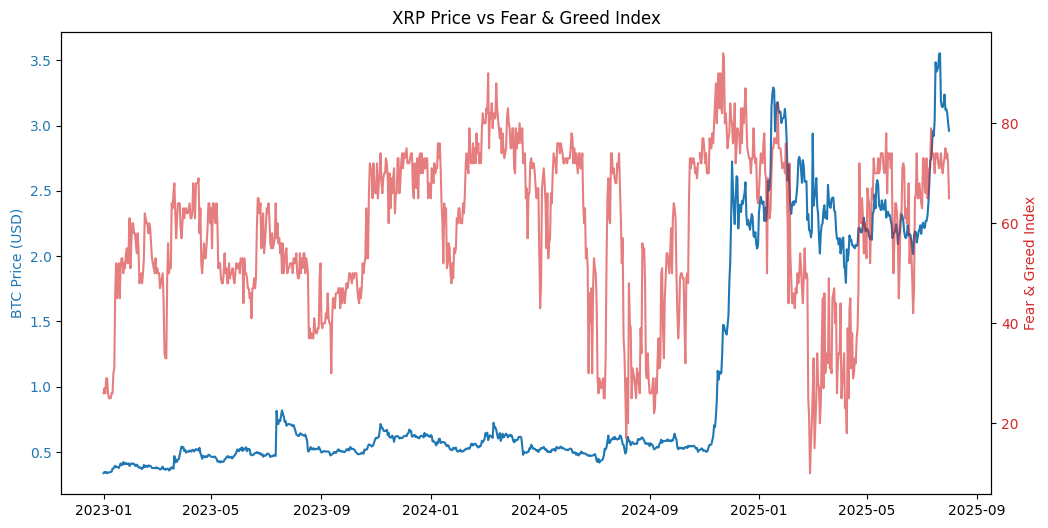

In [70]:
# Cell 9️⃣: Visualization - kiểm tra nhanh

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_final["Date"], df_final["Close"], color='tab:blue', label="Price (Close)")
ax1.set_ylabel("BTC Price (USD)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Fear & Greed (chuẩn hóa thang 0–100)
if "fetch_fear_greed" in df_final.columns:
    ax2 = ax1.twinx()
    ax2.plot(df_final["Date"], df_final["fetch_fear_greed"], color='tab:red', alpha=0.6, label="Fear & Greed")
    ax2.set_ylabel("Fear & Greed Index", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"{SYMBOL_BASE} Price vs Fear & Greed Index")
plt.show()


# Tổng hợp dữ liệu
    Chuẩn hóa dataset cho 1 đồng coin.
    - Tự tìm file dataset gốc mới nhất trong data/<COIN>/
    - Làm sạch, chuẩn hóa, thêm biến log_return, pct_change, sentiment, v.v.

Chỉnh dòng này nếu muốn xử lý từng phần (nên)

In [81]:
SYMBOL_BASE = "XRP"             # ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"

In [82]:
# Cell 🔟: Xử lý & Chuẩn hóa dữ liệu (phiên bản tối ưu)

def process_and_clean_dataset(symbol_base: str):

    # Tìm thư mục và file gốc
    data_dir = os.path.join("data", symbol_base)
    os.makedirs(data_dir, exist_ok=True)

    # Tự động lấy file CSV mới nhất trong thư mục
    csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset_*.csv")), key=os.path.getmtime)
    if not csv_files:
        print(f"⚠️ Không tìm thấy file dữ liệu nào trong {data_dir}")
        return None
    latest_file = csv_files[-1]  # file mới nhất
    print(f"📂 Đang đọc file mới nhất: {os.path.basename(latest_file)}")

    # Đọc dữ liệu
    df = pd.read_csv(latest_file)
    print(f"📏 {df.shape[0]} dòng, {df.shape[1]} cột ban đầu")

    # --- 1️⃣ Làm sạch & chuyển kiểu dữ liệu ---
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    num_cols = ["Open","High","Low","Close","Volume","Quote_Volume","Number_Of_Trades",
                "funding_Rate","fetch_fear_greed","active_addresses","hash_rate",
                "tx_count","miners_revenue","google_interest"]

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)

    # --- 2️⃣ Xử lý missing ---
    df["funding_Rate"] = df["funding_Rate"].fillna(0)
    for col in ["fetch_fear_greed", "google_interest"]:
        if col in df.columns:
            df[col] = df[col].interpolate(limit_direction="both")

    for col in ["hash_rate","tx_count","miners_revenue","active_addresses"]:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # --- 3️⃣ Tạo biến mới ---
    df["pct_change"] = df["Close"].pct_change() * 100
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Close_norm"] = (df["Close"] - df["Close"].min()) / (df["Close"].max() - df["Close"].min())

    if "fetch_fear_greed" in df.columns and "google_interest" in df.columns:
        df["sentiment_mix"] = (
            0.6 * df["fetch_fear_greed"].fillna(df["fetch_fear_greed"].mean()) +
            0.4 * df["google_interest"].fillna(df["google_interest"].mean())
        )

    # --- 4️⃣ Chuẩn hóa output ---
    df_clean = df.copy()
    df_clean = df_clean.dropna(subset=["Close"]).reset_index(drop=True)
    df_clean["symbol"] = symbol_base.upper()

    # --- 5️⃣ Xuất file ---
    out_csv = os.path.join(data_dir, f"dataset_{symbol_base}_clean.csv")
    out_xlsx = os.path.join(data_dir, f"dataset_{symbol_base}_clean.xlsx")

    df_clean.to_csv(out_csv, index=False)
    df_clean.to_excel(out_xlsx, index=False)

    print(f"✅ Đã xử lý & lưu dữ liệu sạch:\n- {out_csv}\n- {out_xlsx}")
    print(f"📈 Tổng số dòng sau xử lý: {len(df_clean)}\n")

    return df_clean


# --- Chạy chính ---
df_clean = process_and_clean_dataset(SYMBOL_BASE)
df_clean.head()


📂 Đang đọc file mới nhất: dataset_XRP_20230101_20250801.csv
📏 944 dòng, 17 cột ban đầu
✅ Đã xử lý & lưu dữ liệu sạch:
- data\XRP\dataset_XRP_clean.csv
- data\XRP\dataset_XRP_clean.xlsx
📈 Tổng số dòng sau xử lý: 944



,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,0.3389,0.3397,0.3352,0.3385,7.176610e+08,XRP,2.423334e+08,230028,1.000000e-04,...,NaN,5.861378e+08,460136.752381,3.753786e+07,3.000000,1d,NaN,NaN,0.000249,16.800000
1,2023-01-02,0.3384,0.3554,0.2968,0.3479,3.188137e+09,XRP,1.071521e+09,922011,-1.878300e-04,...,NaN,2.742413e+08,229347.000000,1.644734e+07,3.142857,1d,2.776957,0.027391,0.003172,17.457143
2,2023-01-03,0.3478,0.3518,0.3400,0.3434,1.676006e+09,XRP,5.781609e+08,507736,-1.348333e-04,...,NaN,5.861378e+08,460136.752381,3.753786e+07,3.285714,1d,-1.293475,-0.013019,0.001773,16.914286
3,2023-01-04,0.3435,0.3527,0.3410,0.3470,1.695313e+09,XRP,5.891357e+08,508688,-4.200000e-07,...,NaN,5.861378e+08,460136.752381,3.753786e+07,3.428571,1d,1.048340,0.010429,0.002892,18.771429
4,2023-01-05,0.3469,0.3485,0.3321,0.3377,1.325149e+09,XRP,4.525935e+08,419255,-3.859000e-05,...,NaN,2.660837e+08,279391.000000,1.719090e+07,3.571429,1d,-2.680115,-0.027167,0.000000,18.828571


## Gộp các dữ liệu lại.

In [83]:
coin_list = ["BTC", "ETH", "BNB", "SOL", "XRP"]   # ⚙️ Thêm hoặc bớt coin tùy bạn
# ví dụ: "BTC", "ETH", "BNB", "SOL", "XRP"

In [84]:
# Cell 1️⃣1️⃣: Gộp tất cả dataset _clean thành 1 file tổng trong thư mục data/

def combine_clean_datasets(coin_list):
    """
    Gộp các file _clean.csv của danh sách coin thành 1 DataFrame lớn.
    Lưu file tổng ngay trong thư mục 'data/'.
    """
    all_dfs = []

    for coin in coin_list:
        data_dir = os.path.join("data", coin)
        clean_files = glob.glob(os.path.join(data_dir, f"dataset_{coin}_clean.csv"))

        if not clean_files:
            print(f"⚠️ Không tìm thấy file clean cho {coin}")
            continue

        latest_file = sorted(clean_files, key=os.path.getmtime)[-1]
        print(f"📂 Đang đọc: {os.path.basename(latest_file)}")
        df = pd.read_csv(latest_file)

        # Bổ sung cột symbol nếu thiếu
        if "symbol" not in df.columns:
            df["symbol"] = coin

        all_dfs.append(df)
        print(f"✅ {coin}: {df.shape[0]} dòng, {df.shape[1]} cột")

    if not all_dfs:
        print("❌ Không có file nào để gộp.")
        return None

    # Gộp & sắp xếp
    df_total = pd.concat(all_dfs, ignore_index=True)
    df_total = df_total.sort_values(["symbol", "Date"]).reset_index(drop=True)

    print(f"\n📊 Tổng cộng {df_total.shape[0]} dòng từ {len(all_dfs)} đồng coin.")
    print(f"📈 Các đồng được gộp: {', '.join(coin_list)}")

    # Xuất file tổng trong thư mục data/
    out_csv = os.path.join("data", "dataset_total_clean.csv")
    out_xlsx = os.path.join("data", "dataset_total_clean.xlsx")

    df_total.to_csv(out_csv, index=False)
    df_total.to_excel(out_xlsx, index=False)

    print(f"💾 Đã lưu file tổng:\n- {out_csv}\n- {out_xlsx}")
    return df_total


# --- Chạy chính ---
df_total = combine_clean_datasets(coin_list)
df_total.head()


📂 Đang đọc: dataset_BTC_clean.csv
✅ BTC: 944 dòng, 21 cột
📂 Đang đọc: dataset_ETH_clean.csv
✅ ETH: 944 dòng, 21 cột
📂 Đang đọc: dataset_BNB_clean.csv
✅ BNB: 944 dòng, 21 cột
📂 Đang đọc: dataset_SOL_clean.csv
✅ SOL: 944 dòng, 21 cột
📂 Đang đọc: dataset_XRP_clean.csv
✅ XRP: 944 dòng, 21 cột

📊 Tổng cộng 4720 dòng từ 5 đồng coin.
📈 Các đồng được gộp: BTC, ETH, BNB, SOL, XRP
💾 Đã lưu file tổng:
- data\dataset_total_clean.csv
- data\dataset_total_clean.xlsx


,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,active_addresses,hash_rate,tx_count,miners_revenue,google_interest,time_frame,pct_change,log_return,Close_norm,sentiment_mix
0,2023-01-01,246.11,246.59,243.25,244.36,793153.38,BNB,1.939856e+08,246426,-0.000003,...,NaN,5.861378e+08,460136.752381,3.753786e+07,76.000000,1d,NaN,NaN,0.061094,46.000000
1,2023-01-02,244.35,247.88,240.40,245.07,1476135.06,BNB,3.620143e+08,407787,-0.000025,...,NaN,2.742413e+08,229347.000000,1.644734e+07,75.857143,1d,0.290555,0.002901,0.062204,46.542857
2,2023-01-03,245.06,246.90,244.02,245.97,917619.33,BNB,2.252540e+08,287346,-0.000052,...,NaN,5.861378e+08,460136.752381,3.753786e+07,75.714286,1d,0.367242,0.003666,0.063611,45.885714
3,2023-01-04,245.97,260.90,245.47,258.54,2601842.57,BNB,6.647247e+08,747686,0.000000,...,NaN,5.861378e+08,460136.752381,3.753786e+07,75.571429,1d,5.110379,0.049841,0.083267,47.628571
4,2023-01-05,258.55,258.90,255.00,256.44,1016972.84,BNB,2.612803e+08,344953,-0.000396,...,NaN,2.660837e+08,279391.000000,1.719090e+07,75.428571,1d,-0.812253,-0.008156,0.079983,47.571429


In [85]:
# Cell 1️⃣1️⃣b: Đổi tên các cột cho đồng nhất & dễ đọc

import os
import pandas as pd

# 🔧 Đường dẫn file tổng hiện tại (có thể đổi nếu cần)
file_path = "data/dataset_total_clean.csv"

# Đọc dữ liệu
df = pd.read_csv(file_path)
print(f"📂 Đã đọc file: {file_path}")
print(f"📏 Trước đổi tên: {df.shape[1]} cột")

# 🧩 Đổi tên các cột mong muốn
rename_map = {
    "fetch_fear_greed": "fear_greed_index",
    "google_interest": "google_trend_score",
    "Close_norm": "close_norm",
    "active_addresses": "onchain_active_addresses"
}

# Chỉ đổi nếu cột tồn tại
existing = [c for c in rename_map.keys() if c in df.columns]
df = df.rename(columns={k: rename_map[k] for k in existing})

print(f"✅ Đã đổi tên {len(existing)} cột:")
for old, new in rename_map.items():
    if old in existing:
        print(f"   • {old} → {new}")

# 💾 Lưu lại — bạn có thể chọn:
SAVE_OVERWRITE = True   # ⚙️ Đổi thành False nếu muốn lưu bản mới

if SAVE_OVERWRITE:
    out_csv = file_path
    out_xlsx = "data/dataset_total_clean.xlsx"
else:
    out_csv = "data/dataset_total_clean_renamed.csv"
    out_xlsx = "data/dataset_total_clean_renamed.xlsx"

df.to_csv(out_csv, index=False)
df.to_excel(out_xlsx, index=False)

print(f"💾 Đã lưu lại:\n- {out_csv}\n- {out_xlsx}")
print("\n📑 Danh sách cột sau khi đổi tên:")
print(df.columns.tolist()[:15], "...")


📂 Đã đọc file: data/dataset_total_clean.csv
📏 Trước đổi tên: 21 cột
✅ Đã đổi tên 4 cột:
   • fetch_fear_greed → fear_greed_index
   • google_interest → google_trend_score
   • Close_norm → close_norm
   • active_addresses → onchain_active_addresses
💾 Đã lưu lại:
- data/dataset_total_clean.csv
- data/dataset_total_clean.xlsx

📑 Danh sách cột sau khi đổi tên:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'symbol', 'Quote_Volume', 'Number_Of_Trades', 'funding_Rate', 'fear_greed_index', 'onchain_active_addresses', 'hash_rate', 'tx_count', 'miners_revenue'] ...


In [116]:
#Kiểm tra trùng lặp logic
df.duplicated(['Date','symbol']).sum()


if 'onchain_active_addresses' in df.columns:
    df = df.drop(columns=['onchain_active_addresses'])
    print("✅ Đã xoá cột 'onchain_active_addresses' khỏi dataset.")
else:
    print("⚠️ Không tìm thấy cột 'onchain_active_addresses'.")


✅ Đã xoá cột 'onchain_active_addresses' khỏi dataset.


# Truy vấn liên quan

1. Đọc dữ liệu.

Tự động đọc từ CSV hoặc Excel

In [86]:
DATA_DIR = "data"

try:
    df = pd.read_csv(os.path.join(DATA_DIR, "dataset_total_clean.csv"))
except FileNotFoundError:
    df = pd.read_excel(os.path.join(DATA_DIR, "dataset_total_clean.xlsx"))

# --- Kiểm tra ---
print("✅ Dữ liệu đã đọc thành công!")
print("🧾 Danh sách cột:", list(df.columns))
print("Số dòng:", len(df))

✅ Dữ liệu đã đọc thành công!
🧾 Danh sách cột: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'symbol', 'Quote_Volume', 'Number_Of_Trades', 'funding_Rate', 'fear_greed_index', 'onchain_active_addresses', 'hash_rate', 'tx_count', 'miners_revenue', 'google_trend_score', 'time_frame', 'pct_change', 'log_return', 'close_norm', 'sentiment_mix']
Số dòng: 4720


In [88]:
df.head()

,Date,Open,High,Low,Close,Volume,symbol,Quote_Volume,Number_Of_Trades,funding_Rate,...,onchain_active_addresses,hash_rate,tx_count,miners_revenue,google_trend_score,time_frame,pct_change,log_return,close_norm,sentiment_mix
0,2023-01-01,246.11,246.59,243.25,244.36,793153.38,BNB,1.939856e+08,246426,-0.000003,...,NaN,5.861378e+08,460136.752381,3.753786e+07,76.000000,1d,NaN,NaN,0.061094,46.000000
1,2023-01-02,244.35,247.88,240.40,245.07,1476135.06,BNB,3.620143e+08,407787,-0.000025,...,NaN,2.742413e+08,229347.000000,1.644734e+07,75.857143,1d,0.290555,0.002901,0.062204,46.542857
2,2023-01-03,245.06,246.90,244.02,245.97,917619.33,BNB,2.252540e+08,287346,-0.000052,...,NaN,5.861378e+08,460136.752381,3.753786e+07,75.714286,1d,0.367242,0.003666,0.063611,45.885714
3,2023-01-04,245.97,260.90,245.47,258.54,2601842.57,BNB,6.647247e+08,747686,0.000000,...,NaN,5.861378e+08,460136.752381,3.753786e+07,75.571429,1d,5.110379,0.049841,0.083267,47.628571
4,2023-01-05,258.55,258.90,255.00,256.44,1016972.84,BNB,2.612803e+08,344953,-0.000396,...,NaN,2.660837e+08,279391.000000,1.719090e+07,75.428571,1d,-0.812253,-0.008156,0.079983,47.571429


In [90]:
# =====================================================
# 1️⃣ Trung bình giá BTC theo tháng
# =====================================================
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

monthly_price = df.groupby(df['Date'].dt.to_period('M'))['Close'].mean().reset_index()
monthly_price['Date'] = monthly_price['Date'].astype(str)
print("\n1️⃣ Trung bình giá BTC theo tháng:")
print(monthly_price.head())


1️⃣ Trung bình giá BTC theo tháng:
      Date        Close
0  2023-01  4402.195901
1  2023-02  5049.552286
2  2023-03  5413.455615
3  2023-04  6217.291601
4  2023-05  5930.207310


In [91]:
# =====================================================
# 2️⃣ Độ biến động (volatility) hàng tháng
# =====================================================
monthly_volatility = df.groupby(df['Date'].dt.to_period('M'))['log_return'].std().reset_index()
monthly_volatility['Date'] = monthly_volatility['Date'].astype(str)
print("\n2️⃣ Độ biến động log_return hàng tháng:")
print(monthly_volatility.head())


2️⃣ Độ biến động log_return hàng tháng:
      Date  log_return
0  2023-01    0.044053
1  2023-02    0.031217
2  2023-03    0.040445
3  2023-04    0.026833
4  2023-05    0.020104


In [92]:
# =====================================================
# 3️⃣ Quan hệ giữa Funding Rate và log_return
# =====================================================
corr_funding_return = df[['funding_Rate','log_return']].corr().iloc[0,1]
print(f"\n3️⃣ Tương quan giữa funding_Rate và log_return: {corr_funding_return:.4f}")



3️⃣ Tương quan giữa funding_Rate và log_return: 0.0032


In [93]:
# =====================================================
# 4️⃣ Ảnh hưởng sentiment đến biến động giá
# =====================================================
corr_sentiment_pct = df[['sentiment_mix','pct_change']].corr().iloc[0,1]
print(f"\n4️⃣ Tương quan giữa sentiment_mix và pct_change: {corr_sentiment_pct:.4f}")



4️⃣ Tương quan giữa sentiment_mix và pct_change: 0.0180


In [94]:
# =====================================================
# 5️⃣ Mối liên hệ giữa hash_rate, active_addresses và giá
# =====================================================
corr_network = df[['hash_rate','onchain_active_addresses','Close']].corr()
print("\n5️⃣ Tương quan mạng lưới và giá:")
print(corr_network)


5️⃣ Tương quan mạng lưới và giá:
                          hash_rate  onchain_active_addresses     Close
hash_rate                  1.000000                       NaN  0.120663
onchain_active_addresses        NaN                       NaN       NaN
Close                      0.120663                       NaN  1.000000


In [95]:
# =====================================================
# 6️⃣ So sánh Funding Rate trung bình giữa 3 tháng đầu & cuối
# =====================================================
first_3m = df.head(90)['funding_Rate'].mean()
last_3m = df.tail(90)['funding_Rate'].mean()
print(f"\n6️⃣ Funding Rate TB 3 tháng đầu: {first_3m:.6f} | 3 tháng cuối: {last_3m:.6f}")


6️⃣ Funding Rate TB 3 tháng đầu: -0.000130 | 3 tháng cuối: 0.000062


In [96]:
# =====================================================
# 7️⃣ Top 5 ngày tăng & giảm mạnh nhất
# =====================================================
top5_up = df.nlargest(5, 'pct_change')[['Date','pct_change','Close']]
top5_down = df.nsmallest(5, 'pct_change')[['Date','pct_change','Close']]
print("\n7️⃣ Top 5 ngày tăng mạnh nhất:")
print(top5_up)
print("\nTop 5 ngày giảm mạnh nhất:")
print(top5_down)


7️⃣ Top 5 ngày tăng mạnh nhất:
           Date  pct_change    Close
3969 2023-07-13   73.231358   0.8154
4567 2025-03-02   34.149014   2.9384
2845 2023-01-14   32.773798  24.2830
3855 2023-03-21   25.743370   0.4694
4461 2024-11-16   25.728373   1.1220

Top 5 ngày giảm mạnh nhất:
           Date  pct_change      Close
3624 2025-03-03  -20.482535   142.0500
4568 2025-03-03  -18.799347     2.3860
3617 2025-02-24  -15.556482   141.7300
4484 2024-12-09  -15.016711     2.2122
2680 2025-03-03  -14.655638  2148.2200


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\615097083.py:14: UserWarning: Glyph 128310 (\N{LARGE ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128310 (\N{LARGE ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


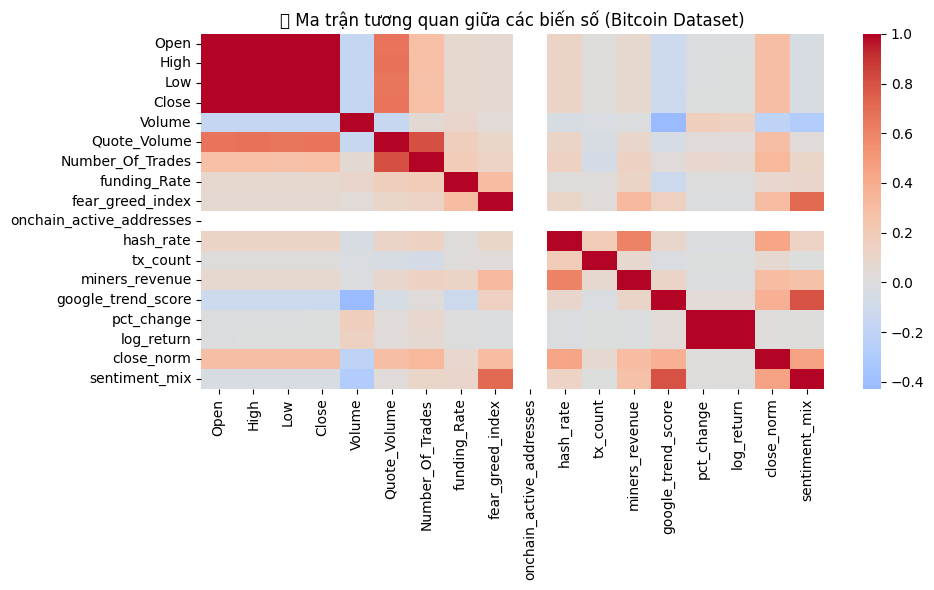


8️⃣ Heatmap hiển thị tương quan giữa các biến số thành công ✅


In [97]:
# =====================================================
# 8️⃣ Ma trận tương quan toàn cục (Heatmap)
# =====================================================

import seaborn as sns
import matplotlib.pyplot as plt

# Lọc ra các cột có kiểu dữ liệu số để tránh lỗi
df_numeric = df.select_dtypes(include=['number'])

plt.figure(figsize=(10,6))
sns.heatmap(df_numeric.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("🔶 Ma trận tương quan giữa các biến số (Bitcoin Dataset)")
plt.tight_layout()
plt.show()

print("\n8️⃣ Heatmap hiển thị tương quan giữa các biến số thành công ✅")


In [98]:
# =====================================================
# 9️⃣ Ảnh hưởng chỉ số Fear & Greed đến biến động giá Bitcoin
# =====================================================

if 'fear_greed_index' in df.columns and 'pct_change' in df.columns:
    # Ép kiểu dữ liệu về số, loại bỏ giá trị thiếu
    df['fear_greed_index'] = pd.to_numeric(df['fear_greed_index'], errors='coerce')
    df['pct_change'] = pd.to_numeric(df['pct_change'], errors='coerce')
    subset = df[['fear_greed_index','pct_change']].dropna()

    if len(subset) > 2:
        corr_fear_greed = subset.corr().iloc[0,1]
        print(f"\n9️⃣ Tương quan giữa Fear & Greed Index và Biến động giá BTC: {corr_fear_greed:.4f}")

        if corr_fear_greed > 0.3:
            print("   📈 Khi thị trường tham lam, giá có xu hướng tăng.")
        elif corr_fear_greed < -0.3:
            print("   📉 Khi thị trường sợ hãi, giá có xu hướng giảm.")
        else:
            print("   ⚖️ Mối quan hệ yếu hoặc không rõ ràng.")
    else:
        print("\n9️⃣ ⚠️ Không đủ dữ liệu hợp lệ để tính tương quan Fear & Greed.")
else:
    print("\n9️⃣ ⚠️ Không tìm thấy cột fear_greed_index hoặc pct_change trong dataset.")



9️⃣ Tương quan giữa Fear & Greed Index và Biến động giá BTC: -0.0140
   ⚖️ Mối quan hệ yếu hoặc không rõ ràng.


In [99]:
# =====================================================
# 🔟 So sánh trung bình giá BTC theo 3 giai đoạn (đầu, giữa, cuối kỳ)
# =====================================================
if 'Close' in df.columns:
    n = len(df)
    early = df.iloc[:n//3]['Close'].mean()
    mid = df.iloc[n//3:2*n//3]['Close'].mean()
    late = df.iloc[2*n//3:]['Close'].mean()

    print(f"\n🔟 Trung bình giá BTC theo 3 giai đoạn:")
    print(f"   • Đầu kỳ  : {early:.2f}")
    print(f"   • Giữa kỳ : {mid:.2f}")
    print(f"   • Cuối kỳ : {late:.2f}")

    if late > early:
        print("   📈 → Giá BTC tăng dần về cuối kỳ.")
    elif late < early:
        print("   📉 → Giá BTC giảm dần về cuối kỳ.")
    else:
        print("   ⚖️ → Giá BTC gần như không thay đổi theo thời gian.")
else:
    print("\n🔟 ⚠️ Không tìm thấy cột Close trong dataset.")


🔟 Trung bình giá BTC theo 3 giai đoạn:
   • Đầu kỳ  : 17028.04
   • Giữa kỳ : 20156.33
   • Cuối kỳ : 61.41
   📉 → Giá BTC giảm dần về cuối kỳ.


## Phân tích dữ liệu Bitcoin (BTC) — 10 Hướng Truy Vấn Chính

---

### 1️⃣ Xu hướng giá BTC theo thời gian  
**Câu hỏi:** BTC có xu hướng tăng hay giảm trong dài hạn?  
***Dữ liệu sử dụng:*** `Close` hoặc `Adj Close` theo **ngày / tuần / tháng**  
***Mục tiêu:*** Xác định xu hướng dài hạn của giá BTC.


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\3882041858.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_price.resample('M', on='Date').mean().reset_index()


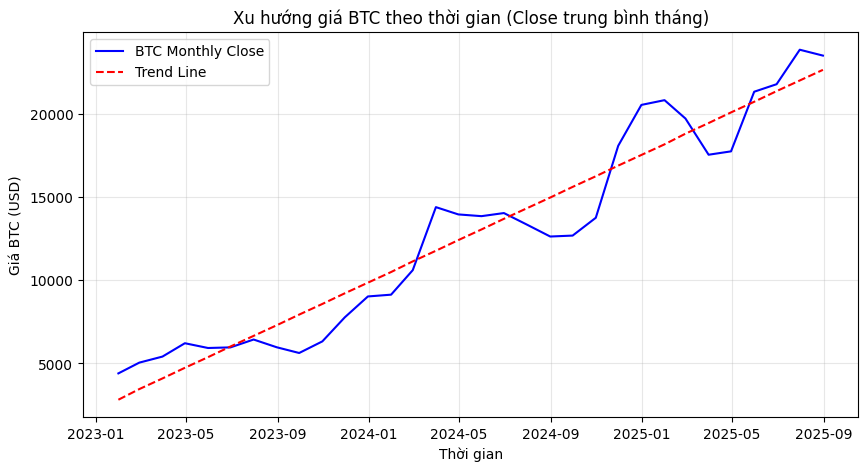

Hệ số dốc (slope): 640.5397
Hệ số tương quan (R): 0.9621
📈 Giá BTC có xu hướng TĂNG dài hạn.


In [100]:
# --- 1. Đọc dữ liệu ---
# Nếu file của bạn nằm trong thư mục data
df = pd.read_csv("data/dataset_total_clean.csv")  # hoặc .xlsx
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# --- 2. Chọn cột cần thiết ---
df_price = df[['Date', 'Close']].copy()

# --- 3. Tính trung bình giá theo tháng để làm mượt xu hướng ---
df_monthly = df_price.resample('M', on='Date').mean().reset_index()

# --- 4. Tính đường xu hướng tuyến tính (linear regression) ---
slope, intercept, r_value, p_value, std_err = linregress(
    range(len(df_monthly)), df_monthly['Close']
)
trend = slope * range(len(df_monthly)) + intercept

# --- 5. Hiển thị kết quả ---
plt.figure(figsize=(10,5))
plt.plot(df_monthly['Date'], df_monthly['Close'], label='BTC Monthly Close', color='blue')
plt.plot(df_monthly['Date'], trend, label='Trend Line', color='red', linestyle='--')
plt.title('Xu hướng giá BTC theo thời gian (Close trung bình tháng)')
plt.xlabel('Thời gian')
plt.ylabel('Giá BTC (USD)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 6. In kết quả định lượng ---
print("Hệ số dốc (slope):", round(slope, 4))
print("Hệ số tương quan (R):", round(r_value, 4))
if slope > 0:
    print("📈 Giá BTC có xu hướng TĂNG dài hạn.")
elif slope < 0:
    print("📉 Giá BTC có xu hướng GIẢM dài hạn.")
else:
    print("⚖️ Giá BTC ổn định, không có xu hướng rõ ràng.")


---

### 2️⃣ Biến động giá trong ngày (High – Low) và Volatility  
**Câu hỏi:** Ngày nào biến động mạnh, ngày nào ổn định?  
**Dữ liệu sử dụng:** `High`, `Low`, `log_return`  
**Mục tiêu:** Đo lường biến động và xác định các giai đoạn rủi ro cao.


📊 Thống kê biến động giá trong ngày:
                      Date           High            Low          Close  \
count                 4720    4720.000000    4720.000000    4720.000000   
mean   2024-04-16 12:00:00   12633.867125   12155.553389   12412.642277   
min    2023-01-01 00:00:00       0.339700       0.296800       0.337700   
25%    2023-08-24 18:00:00      24.803500      22.829000      23.870250   
50%    2024-04-16 12:00:00     545.425000     514.340000     531.870000   
75%    2024-12-08 06:00:00    3147.270000    2968.060000    3070.247500   
max    2025-08-01 00:00:00  123300.000000  118862.600000  119993.700000   
std                    NaN   27203.761666   26211.522588   26745.620466   

        Daily_Range  Volatility_%  
count   4720.000000   4720.000000  
mean     478.313737      5.266126  
min        0.003400      0.373886  
25%        1.968250      2.858130  
50%       17.458500      4.255610  
75%      155.487500      6.524410  
max    14430.400000     60.804513 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\2000288632.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_vol = df.resample('M', on='Date')['log_return'].std().reset_index()


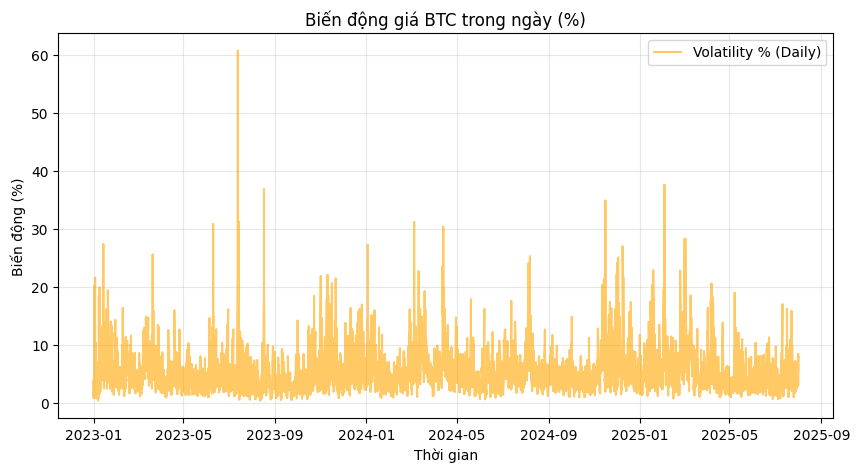

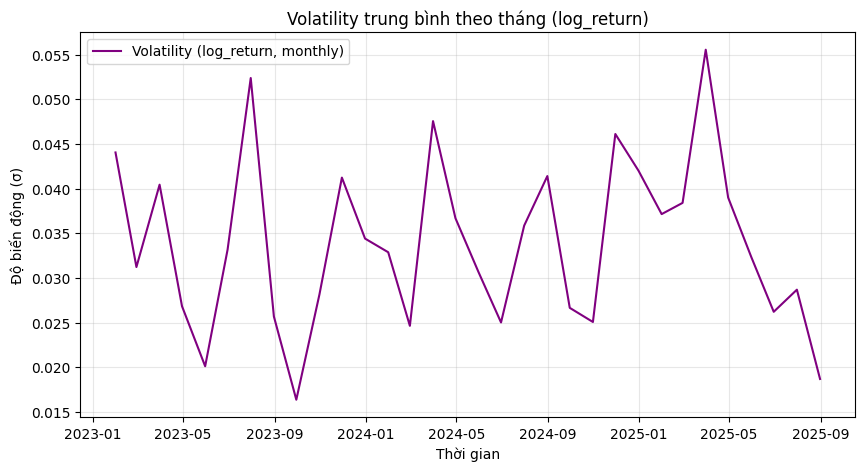

In [101]:
# --- 1. Đọc và xử lý dữ liệu ---
df = pd.read_csv("data/dataset_total_clean.csv")  # hoặc Excel
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# --- 2. Tính toán biến động trong ngày ---
df['Daily_Range'] = df['High'] - df['Low']
df['Volatility_%'] = (df['Daily_Range'] / df['Close']) * 100  # % biến động so với giá đóng cửa

# --- 3. Thống kê nhanh ---
print("\n📊 Thống kê biến động giá trong ngày:")
print(df[['Date','High','Low','Close','Daily_Range','Volatility_%']].describe())

# --- 4. Top 5 ngày biến động mạnh nhất & ổn định nhất ---
top_volatile = df.nlargest(5, 'Volatility_%')[['Date','Volatility_%','Close']]
least_volatile = df.nsmallest(5, 'Volatility_%')[['Date','Volatility_%','Close']]
print("\n🔥 Top 5 ngày biến động mạnh nhất:")
print(top_volatile)
print("\n🧊 Top 5 ngày ổn định nhất:")
print(least_volatile)

# --- 5. Tính Volatility trung bình theo tháng (dùng log_return) ---
df['log_return'] = pd.to_numeric(df['log_return'], errors='coerce')
monthly_vol = df.resample('M', on='Date')['log_return'].std().reset_index()
monthly_vol.rename(columns={'log_return':'Monthly_Volatility'}, inplace=True)

# --- 6. Vẽ biểu đồ ---
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Volatility_%'], color='orange', alpha=0.6, label='Volatility % (Daily)')
plt.title("Biến động giá BTC trong ngày (%)")
plt.xlabel("Thời gian")
plt.ylabel("Biến động (%)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(monthly_vol['Date'], monthly_vol['Monthly_Volatility'], color='purple', label='Volatility (log_return, monthly)')
plt.title("Volatility trung bình theo tháng (log_return)")
plt.xlabel("Thời gian")
plt.ylabel("Độ biến động (σ)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


---

### 3️⃣ Khối lượng giao dịch và số lượng giao dịch  
**Câu hỏi:** Thời điểm nào thị trường sôi động nhất?  
**Dữ liệu sử dụng:** `Volume`, `Number_Of_Trades`  
**Mục tiêu:** Phân tích thanh khoản và hoạt động giao dịch theo thời gian.


📊 Thống kê khối lượng và số lượng giao dịch:
             Volume  Number_Of_Trades
count  4.720000e+03      4.720000e+03
mean   2.733385e+08      2.356328e+06
std    7.632470e+08      1.966199e+06
min    3.567042e+04      1.416380e+05
25%    6.653104e+05      8.608048e+05
50%    3.059008e+06      1.811066e+06
75%    3.221279e+07      3.257958e+06
max    1.530986e+10      1.866214e+07

🔗 Tương quan giữa Volume và Number_Of_Trades: 0.0552

🔥 Top 5 ngày có khối lượng giao dịch lớn nhất:
           Date        Volume
3969 2023-07-13  1.530986e+10
3855 2023-03-21  1.007043e+10
3970 2023-07-14  9.256523e+09
4477 2024-12-02  9.044623e+09
4461 2024-11-16  8.845498e+09

💥 Top 5 ngày có số lượng giao dịch nhiều nhất:
           Date  Number_Of_Trades
4477 2024-12-02          18662136
4478 2024-12-03          16950348
2652 2025-02-03          16305538
4540 2025-02-03          14710835
2470 2024-08-05          14541848


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\1597584459.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M', on='Date')[['Volume', 'Number_Of_Trades']]


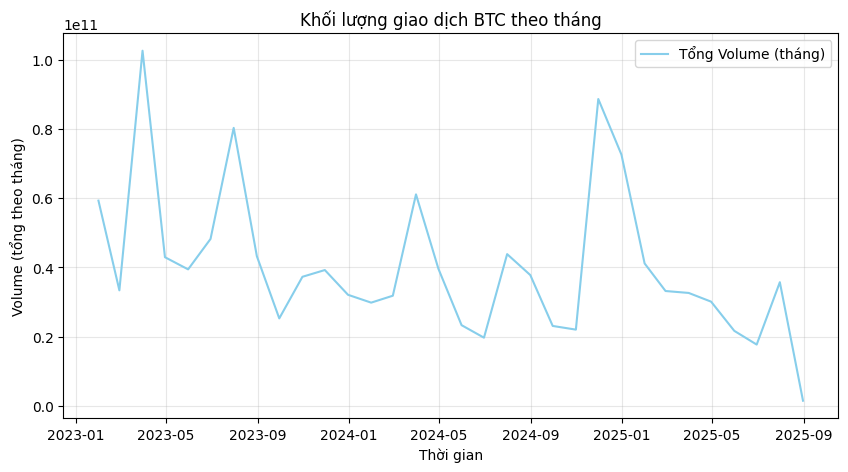

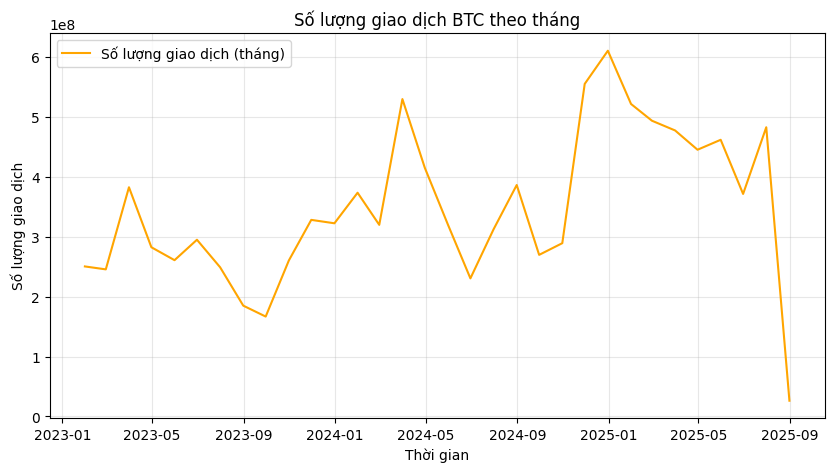

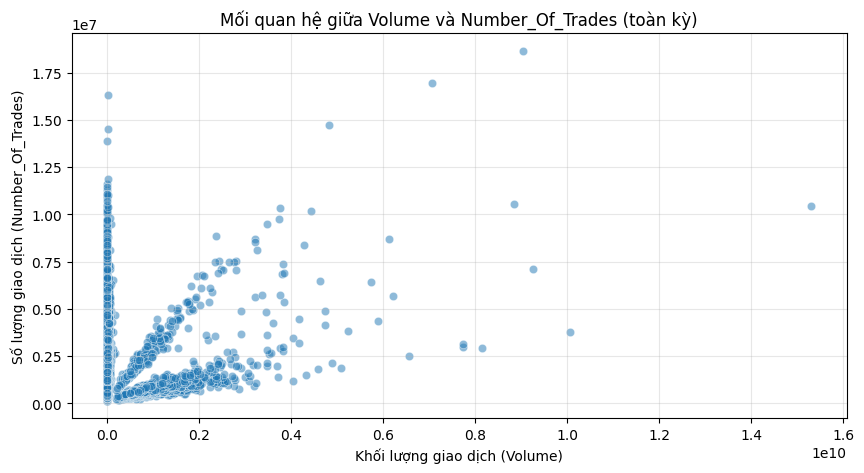

In [102]:
# --- 1. Đọc dữ liệu ---
df = pd.read_csv("data/dataset_total_clean.csv")  # hoặc Excel
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# --- 2. Kiểm tra cột ---
if 'Volume' not in df.columns or 'Number_Of_Trades' not in df.columns:
    raise KeyError("⚠️ Thiếu cột 'Volume' hoặc 'Number_Of_Trades' trong dataset!")

# --- 3. Tổng hợp dữ liệu theo tháng để quan sát xu hướng ---
monthly_trade = (
    df.resample('M', on='Date')[['Volume', 'Number_Of_Trades']]
    .sum()
    .reset_index()
)

# --- 4. Thống kê mô tả ---
print("\n📊 Thống kê khối lượng và số lượng giao dịch:")
print(df[['Volume', 'Number_Of_Trades']].describe())

# --- 5. Tính tương quan giữa Volume và Number_Of_Trades ---
corr_volume_trades = df[['Volume', 'Number_Of_Trades']].corr().iloc[0, 1]
print(f"\n🔗 Tương quan giữa Volume và Number_Of_Trades: {corr_volume_trades:.4f}")

# --- 6. Tìm các giai đoạn sôi động nhất ---
top_volume = df.nlargest(5, 'Volume')[['Date', 'Volume']]
top_trades = df.nlargest(5, 'Number_Of_Trades')[['Date', 'Number_Of_Trades']]
print("\n🔥 Top 5 ngày có khối lượng giao dịch lớn nhất:")
print(top_volume)
print("\n💥 Top 5 ngày có số lượng giao dịch nhiều nhất:")
print(top_trades)

# --- 7. Biểu đồ khối lượng & số lượng giao dịch ---
plt.figure(figsize=(10, 5))
plt.plot(monthly_trade['Date'], monthly_trade['Volume'], label='Tổng Volume (tháng)', color='skyblue')
plt.title("Khối lượng giao dịch BTC theo tháng")
plt.xlabel("Thời gian")
plt.ylabel("Volume (tổng theo tháng)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(monthly_trade['Date'], monthly_trade['Number_Of_Trades'], label='Số lượng giao dịch (tháng)', color='orange')
plt.title("Số lượng giao dịch BTC theo tháng")
plt.xlabel("Thời gian")
plt.ylabel("Số lượng giao dịch")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 8. Biểu đồ kết hợp Volume và Number_Of_Trades ---
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Volume', y='Number_Of_Trades', alpha=0.5)
plt.title("Mối quan hệ giữa Volume và Number_Of_Trades (toàn kỳ)")
plt.xlabel("Khối lượng giao dịch (Volume)")
plt.ylabel("Số lượng giao dịch (Number_Of_Trades)")
plt.grid(alpha=0.3)
plt.show()


---

### 4️⃣ Phân tích lực mua / bán (TakerBuyBaseVolume & TakerBuyQuoteVolume)  
**Câu hỏi:** Xu hướng thị trường là **bullish** hay **bearish**?  
**Dữ liệu sử dụng:** `TakerBuyBaseVolume`, `TakerBuyQuoteVolume`  
**Mục tiêu:** Đánh giá hành vi thị trường qua khối lượng mua/bán.


📊 Tỷ lệ dòng tiền trung bình (Quote_Volume / Volume): 12397.52
📈 Thị trường có dấu hiệu **bullish** (nhiều dòng tiền vào).


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\1615715966.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ratio = df.resample('M', on='Date')['Volume_Ratio'].mean().reset_index()


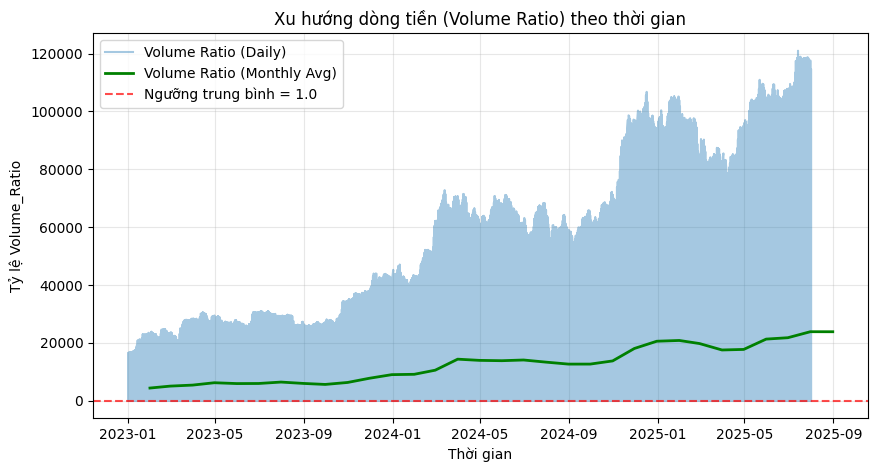


🔗 Tương quan giữa Volume_Ratio và giá BTC: 0.9999


In [103]:
# --- 1. Đọc dữ liệu ---
df = pd.read_csv("data/dataset_total_clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# --- 2. Tính tỷ lệ dòng tiền (proxy cho lực mua/bán) ---
df['Volume_Ratio'] = df['Quote_Volume'] / df['Volume']
df['Volume_Ratio'] = df['Volume_Ratio'].replace([float('inf'), -float('inf')], pd.NA)
df['Volume_Ratio'] = pd.to_numeric(df['Volume_Ratio'], errors='coerce')

# --- 3. Trung bình tháng để xem xu hướng ---
monthly_ratio = df.resample('M', on='Date')['Volume_Ratio'].mean().reset_index()

# --- 4. Phân tích thống kê ---
avg_ratio = df['Volume_Ratio'].mean()
print(f"\n📊 Tỷ lệ dòng tiền trung bình (Quote_Volume / Volume): {avg_ratio:.2f}")

if avg_ratio > 1:
    print("📈 Thị trường có dấu hiệu **bullish** (nhiều dòng tiền vào).")
elif avg_ratio < 1:
    print("📉 Thị trường có dấu hiệu **bearish** (dòng tiền yếu).")
else:
    print("⚖️ Thị trường trung tính, dòng tiền ổn định.")

# --- 5. Biểu đồ xu hướng dòng tiền ---
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Volume_Ratio'], alpha=0.4, label='Volume Ratio (Daily)')
plt.plot(monthly_ratio['Date'], monthly_ratio['Volume_Ratio'], color='green', linewidth=2, label='Volume Ratio (Monthly Avg)')
plt.axhline(1, color='red', linestyle='--', alpha=0.7, label='Ngưỡng trung bình = 1.0')
plt.title("Xu hướng dòng tiền (Volume Ratio) theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("Tỷ lệ Volume_Ratio")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 6. Tương quan giữa dòng tiền và giá ---
if 'Close' in df.columns:
    corr_ratio_price = df[['Volume_Ratio','Close']].corr().iloc[0,1]
    print(f"\n🔗 Tương quan giữa Volume_Ratio và giá BTC: {corr_ratio_price:.4f}")
else:
    print("\n⚠️ Không tìm thấy cột 'Close' để tính tương quan với giá.")


---

### 5️⃣ Tác động của Funding Rate lên giá BTC  
**Câu hỏi:** Funding Rate dương / âm ảnh hưởng như thế nào đến giá?  
**Dữ liệu sử dụng:** `funding_Rate`, `Close`, `log_return`  
**Mục tiêu:** Phân tích mối liên hệ giữa tâm lý trader và biến động giá.

---

### 6️⃣ Hash Rate và Miners’ Revenue  
**Câu hỏi:** Sức mạnh mạng lưới và lợi nhuận miners có liên quan đến giá không?  
**Dữ liệu sử dụng:** `hash_rate`, `miners_revenue`, `Close`  
**Mục tiêu:** Đánh giá mối liên hệ giữa hoạt động khai thác và giá BTC.


🔗 Tương quan giữa Hash Rate và Giá BTC: 0.1207
🔗 Tương quan giữa Miners’ Revenue và Giá BTC: 0.0784
🔗 Tương quan giữa Hash Rate và Miners’ Revenue: 0.6060


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\2408780099.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M', on='Date')[['hash_rate', 'miners_revenue', 'Close']]


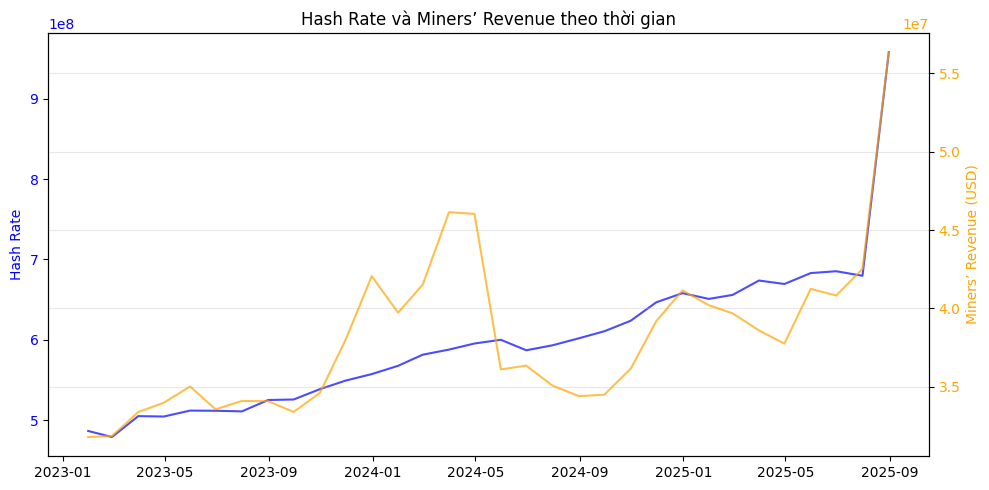

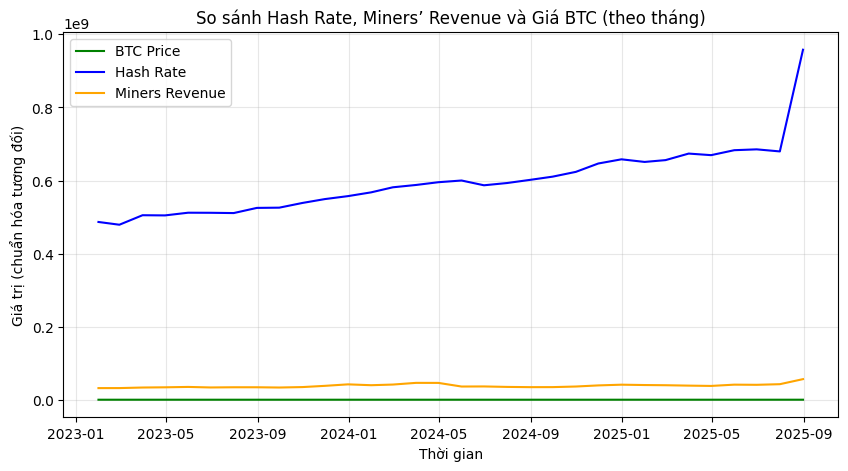

⚖️ Mối quan hệ giữa hoạt động khai thác và giá BTC chưa rõ ràng.


In [104]:
# --- 1. Đọc dữ liệu ---
df = pd.read_csv("data/dataset_total_clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# --- 2. Chuyển kiểu dữ liệu và xử lý thiếu ---
for col in ['hash_rate', 'miners_revenue', 'Close']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- 3. Tính tương quan ---
corr_hash_price = df[['hash_rate', 'Close']].corr().iloc[0,1]
corr_revenue_price = df[['miners_revenue', 'Close']].corr().iloc[0,1]
corr_hash_revenue = df[['hash_rate', 'miners_revenue']].corr().iloc[0,1]

print(f"\n🔗 Tương quan giữa Hash Rate và Giá BTC: {corr_hash_price:.4f}")
print(f"🔗 Tương quan giữa Miners’ Revenue và Giá BTC: {corr_revenue_price:.4f}")
print(f"🔗 Tương quan giữa Hash Rate và Miners’ Revenue: {corr_hash_revenue:.4f}")

# --- 4. Trung bình tháng để thấy xu hướng dài hạn ---
monthly_onchain = (
    df.resample('M', on='Date')[['hash_rate', 'miners_revenue', 'Close']]
    .mean()
    .reset_index()
)

# --- 5. Biểu đồ xu hướng Hash Rate & Revenue ---
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(monthly_onchain['Date'], monthly_onchain['hash_rate'], color='blue', label='Hash Rate', alpha=0.7)
ax1.set_ylabel("Hash Rate", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(monthly_onchain['Date'], monthly_onchain['miners_revenue'], color='orange', label='Miners Revenue', alpha=0.7)
ax2.set_ylabel("Miners’ Revenue (USD)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("Hash Rate và Miners’ Revenue theo thời gian")
plt.xlabel("Thời gian")
plt.grid(alpha=0.3)
fig.tight_layout()
plt.show()

# --- 6. Biểu đồ so sánh với giá BTC ---
plt.figure(figsize=(10,5))
sns.lineplot(x='Date', y='Close', data=monthly_onchain, label='BTC Price', color='green')
sns.lineplot(x='Date', y='hash_rate', data=monthly_onchain, label='Hash Rate', color='blue')
sns.lineplot(x='Date', y='miners_revenue', data=monthly_onchain, label='Miners Revenue', color='orange')
plt.title("So sánh Hash Rate, Miners’ Revenue và Giá BTC (theo tháng)")
plt.xlabel("Thời gian")
plt.ylabel("Giá trị (chuẩn hóa tương đối)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 7. Kết luận định tính ---
if corr_hash_price > 0.3 and corr_revenue_price > 0.3:
    print("📈 Hash Rate và Miners’ Revenue có mối quan hệ tích cực với giá BTC → mạng lưới mạnh và lợi nhuận cao hỗ trợ giá.")
elif corr_hash_price < 0 and corr_revenue_price < 0:
    print("📉 Khi hash rate và miners revenue giảm, giá BTC có xu hướng đi xuống.")
else:
    print("⚖️ Mối quan hệ giữa hoạt động khai thác và giá BTC chưa rõ ràng.")


---

### 7️⃣ Số lượng giao dịch (tx_count) và mối liên hệ với giá  
**Câu hỏi:** Nhu cầu giao dịch tăng có đẩy giá BTC lên không?  
**Dữ liệu sử dụng:** `tx_count`, `Close`, `pct_change`  
**Mục tiêu:** Phân tích mối quan hệ giữa nhu cầu mạng lưới và biến động giá.



🔗 Tương quan giữa tx_count và Giá BTC: 0.0097
🔗 Tương quan giữa tx_count và pct_change: -0.0019


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\800653134.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M', on='Date')[['tx_count', 'Close']]


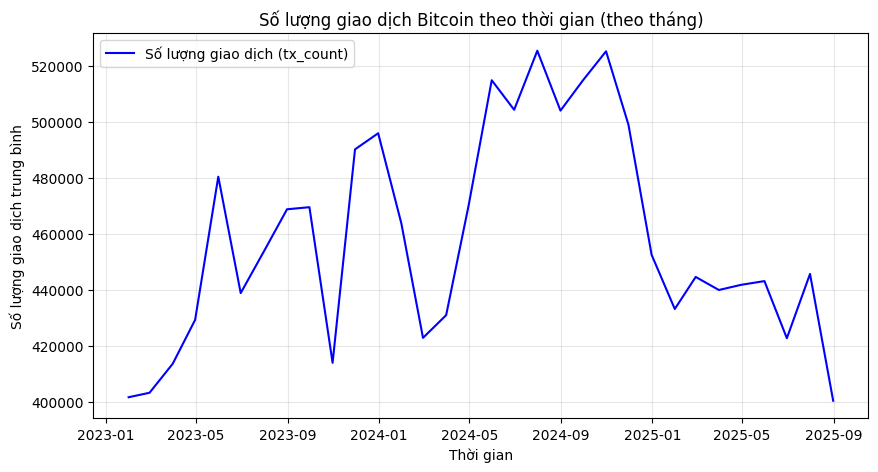

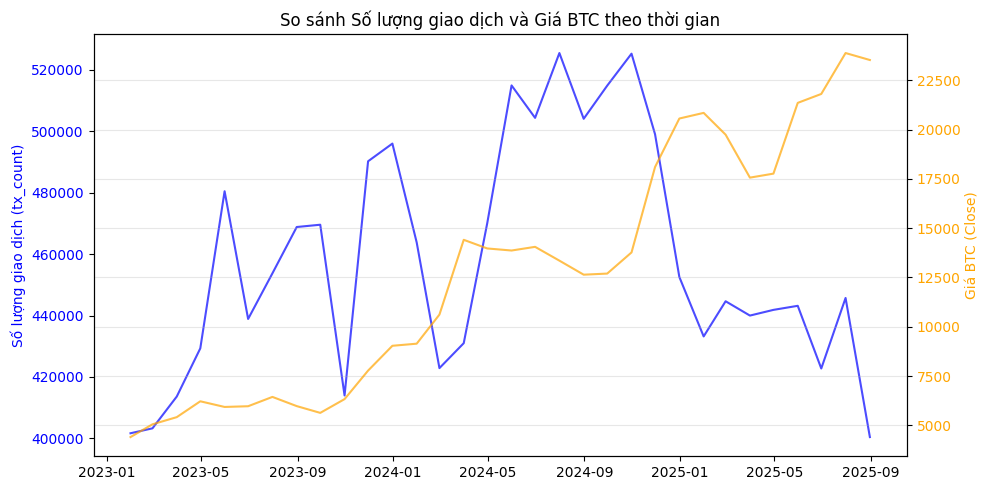

⚖️ Mối liên hệ giữa hoạt động giao dịch và giá BTC không rõ ràng.


In [105]:
# --- 1. Đọc dữ liệu ---
df = pd.read_csv("data/dataset_total_clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# --- 2. Xử lý dữ liệu cần thiết ---
for col in ['tx_count', 'Close', 'pct_change']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- 3. Tính tương quan ---
corr_tx_price = df[['tx_count', 'Close']].corr().iloc[0, 1]
corr_tx_return = df[['tx_count', 'pct_change']].corr().iloc[0, 1]

print(f"\n🔗 Tương quan giữa tx_count và Giá BTC: {corr_tx_price:.4f}")
print(f"🔗 Tương quan giữa tx_count và pct_change: {corr_tx_return:.4f}")

# --- 4. Trung bình theo tháng để xem xu hướng ---
monthly_tx = (
    df.resample('M', on='Date')[['tx_count', 'Close']]
    .mean()
    .reset_index()
)

# --- 5. Biểu đồ xu hướng số lượng giao dịch ---
plt.figure(figsize=(10,5))
plt.plot(monthly_tx['Date'], monthly_tx['tx_count'], color='blue', label='Số lượng giao dịch (tx_count)')
plt.title("Số lượng giao dịch Bitcoin theo thời gian (theo tháng)")
plt.xlabel("Thời gian")
plt.ylabel("Số lượng giao dịch trung bình")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 6. Biểu đồ so sánh số lượng giao dịch và giá ---
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(monthly_tx['Date'], monthly_tx['tx_count'], color='blue', label='Tx Count', alpha=0.7)
ax1.set_ylabel("Số lượng giao dịch (tx_count)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(monthly_tx['Date'], monthly_tx['Close'], color='orange', label='BTC Close', alpha=0.7)
ax2.set_ylabel("Giá BTC (Close)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title("So sánh Số lượng giao dịch và Giá BTC theo thời gian")
plt.xlabel("Thời gian")
plt.grid(alpha=0.3)
fig.tight_layout()
plt.show()

# --- 7. Kết luận định tính ---
if corr_tx_price > 0.3:
    print("📈 Khi số lượng giao dịch tăng, giá BTC có xu hướng tăng (nhu cầu thật).")
elif corr_tx_price < -0.3:
    print("📉 Khi số lượng giao dịch tăng, giá BTC có xu hướng giảm (áp lực bán).")
else:
    print("⚖️ Mối liên hệ giữa hoạt động giao dịch và giá BTC không rõ ràng.")


---

### 8️⃣ Correlation giữa các chỉ số on-chain và giá BTC  
**Câu hỏi:** Chỉ số nào ảnh hưởng mạnh nhất đến giá?  
**Dữ liệu sử dụng:** `hash_rate`, `onchain_active_addresses`, `tx_count`, `miners_revenue`, `Close`  
**Mục tiêu:** Xác định các yếu tố on-chain quan trọng tác động đến giá.


📊 Ma trận tương quan giữa các chỉ số on-chain (loại bỏ cột trống):
                hash_rate  tx_count  miners_revenue  Close
hash_rate           1.000     0.196           0.606  0.121
tx_count            0.196     1.000           0.073  0.010
miners_revenue      0.606     0.073           1.000  0.078
Close               0.121     0.010           0.078  1.000


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\3240004280.py:23: UserWarning: Glyph 128310 (\N{LARGE ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128310 (\N{LARGE ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


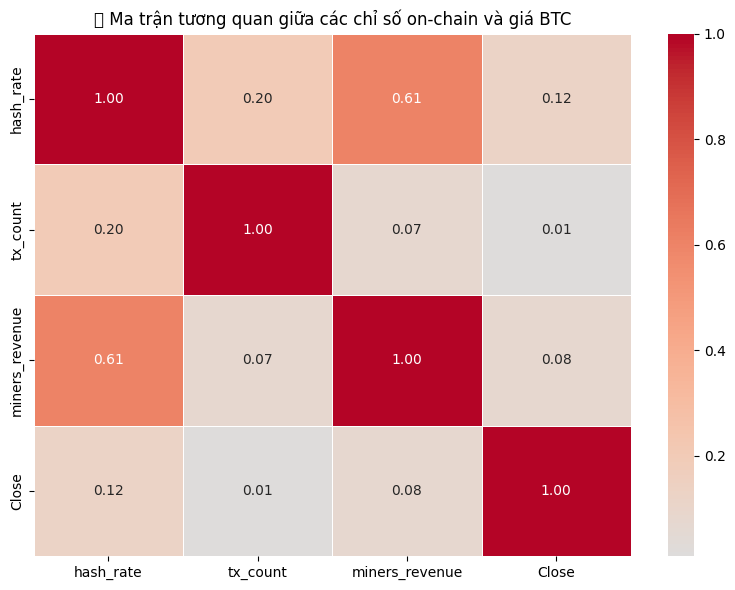


🏆 Chỉ số có tương quan mạnh nhất với giá BTC là **hash_rate** (r = 0.121)
📈 → Chỉ số này có mối quan hệ cùng chiều với giá BTC.


In [106]:
# --- 1. Đọc dữ liệu ---
df = pd.read_csv("data/dataset_total_clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# --- 2. Chọn các cột on-chain cần phân tích (loại bỏ cột trống) ---
onchain_cols = ['hash_rate', 'tx_count', 'miners_revenue', 'Close']

# --- 3. Làm sạch và tính toán như cũ ---
df_onchain = df[onchain_cols].copy().apply(pd.to_numeric, errors='coerce').dropna()
corr_matrix = df_onchain.corr().round(3)

print("\n📊 Ma trận tương quan giữa các chỉ số on-chain (loại bỏ cột trống):")
print(corr_matrix)

# --- 4. Vẽ heatmap ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title("🔶 Ma trận tương quan giữa các chỉ số on-chain và giá BTC")
plt.tight_layout()
plt.show()

# --- 5. Tìm yếu tố ảnh hưởng mạnh nhất ---
corr_with_price = corr_matrix['Close'].drop('Close').sort_values(ascending=False)
strongest_factor = corr_with_price.index[0]
strongest_value = corr_with_price.iloc[0]
print(f"\n🏆 Chỉ số có tương quan mạnh nhất với giá BTC là **{strongest_factor}** (r = {strongest_value:.3f})")

if strongest_value > 0:
    print("📈 → Chỉ số này có mối quan hệ cùng chiều với giá BTC.")
else:
    print("📉 → Chỉ số này có mối quan hệ ngược chiều với giá BTC.")


---

### 9️⃣ Phân tích biến động giá theo tuần / tháng (Seasonality)  
**Câu hỏi:** BTC có xu hướng lên / xuống theo ngày trong tuần hoặc tháng không?  
**Dữ liệu sử dụng:** `Date`, `Close`, `pct_change`  
**Mục tiêu:** Phát hiện các mô hình mùa vụ hoặc chu kỳ giá ngắn hạn.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\3561714055.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_return.index, y=weekday_return.values, palette='viridis')
C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


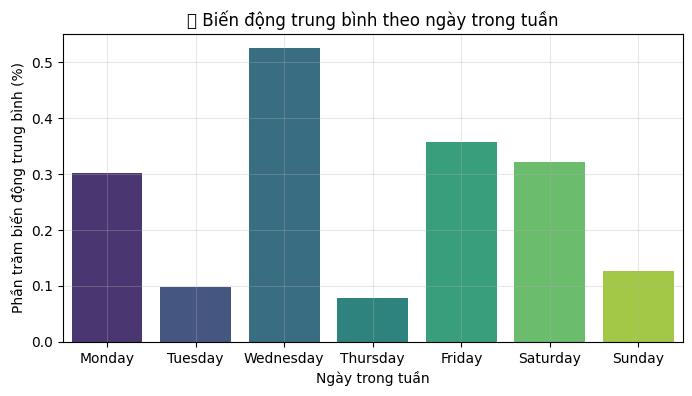

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\3561714055.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_return.index, y=month_return.values, palette='mako')
C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


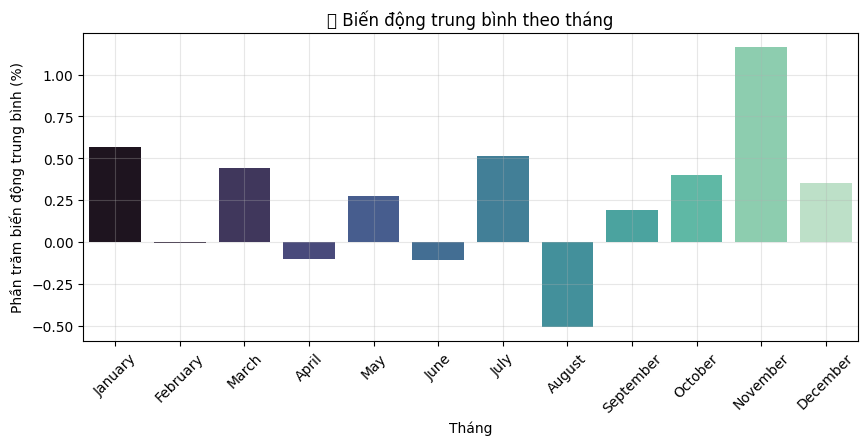


🏆 Ngày trong tuần có hiệu suất cao nhất: Wednesday (52.50%)
📉 Ngày trong tuần yếu nhất: Thursday (7.84%)
🌤️ Tháng có hiệu suất tốt nhất: November (116.39%)
🌧️ Tháng yếu nhất: August (-50.76%)
📈 BTC có xu hướng tăng vào đầu/giữa tuần nhiều hơn.
🟢 Một số tháng có xu hướng tăng mạnh, gợi ý mô hình mùa vụ tích cực.


In [107]:
# --- 1. Đọc dữ liệu ---
df = pd.read_csv("data/dataset_total_clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# --- 2. Chuẩn bị dữ liệu ---
df['pct_change'] = pd.to_numeric(df['pct_change'], errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Thêm cột ngày trong tuần và tháng
df['Weekday'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()

# --- 3. Trung bình phần trăm biến động theo ngày trong tuần ---
weekday_return = df.groupby('Weekday')['pct_change'].mean().reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
])

# --- 4. Trung bình phần trăm biến động theo tháng ---
month_return = df.groupby('Month')['pct_change'].mean().reindex([
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
])

# --- 5. Vẽ biểu đồ Seasonality theo ngày trong tuần ---
plt.figure(figsize=(8,4))
sns.barplot(x=weekday_return.index, y=weekday_return.values, palette='viridis')
plt.title("📆 Biến động trung bình theo ngày trong tuần")
plt.ylabel("Phần trăm biến động trung bình (%)")
plt.xlabel("Ngày trong tuần")
plt.grid(alpha=0.3)
plt.show()

# --- 6. Vẽ biểu đồ Seasonality theo tháng ---
plt.figure(figsize=(10,4))
sns.barplot(x=month_return.index, y=month_return.values, palette='mako')
plt.title("📅 Biến động trung bình theo tháng")
plt.ylabel("Phần trăm biến động trung bình (%)")
plt.xlabel("Tháng")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

# --- 7. Tìm ngày và tháng có hiệu suất cao nhất/thấp nhất ---
best_day = weekday_return.idxmax()
worst_day = weekday_return.idxmin()
best_month = month_return.idxmax()
worst_month = month_return.idxmin()

print(f"\n🏆 Ngày trong tuần có hiệu suất cao nhất: {best_day} ({weekday_return.max():.2%})")
print(f"📉 Ngày trong tuần yếu nhất: {worst_day} ({weekday_return.min():.2%})")
print(f"🌤️ Tháng có hiệu suất tốt nhất: {best_month} ({month_return.max():.2%})")
print(f"🌧️ Tháng yếu nhất: {worst_month} ({month_return.min():.2%})")

# --- 8. Diễn giải nhanh ---
if weekday_return.max() > 0:
    print("📈 BTC có xu hướng tăng vào đầu/giữa tuần nhiều hơn.")
if month_return.max() > 0:
    print("🟢 Một số tháng có xu hướng tăng mạnh, gợi ý mô hình mùa vụ tích cực.")

---

### 🔟 So sánh BTC với các đồng coin khác  
**Câu hỏi:** BTC có ổn định hơn hoặc biến động khác so với các coin khác không?  
**Dữ liệu sử dụng:** `Volume`, `Close`, `pct_change`, `symbol`  
**Mục tiêu:** So sánh đặc điểm thị trường của BTC với các đồng coin khác (ETH, BNB, v.v.).


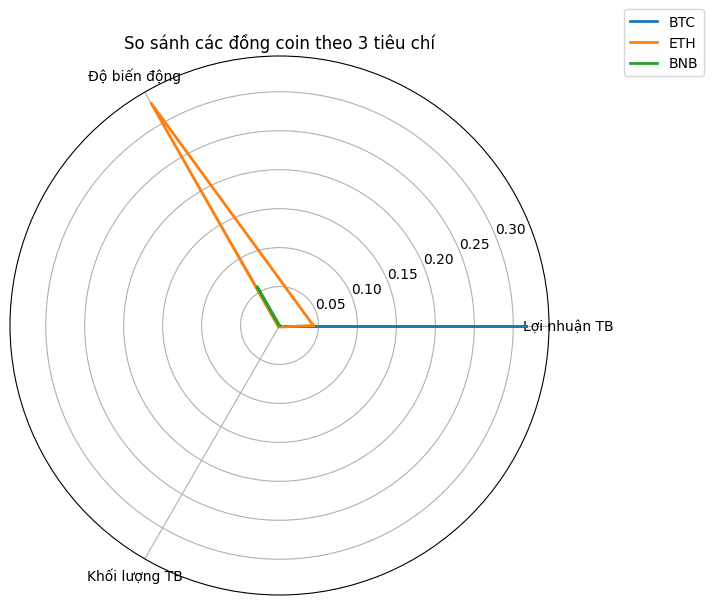

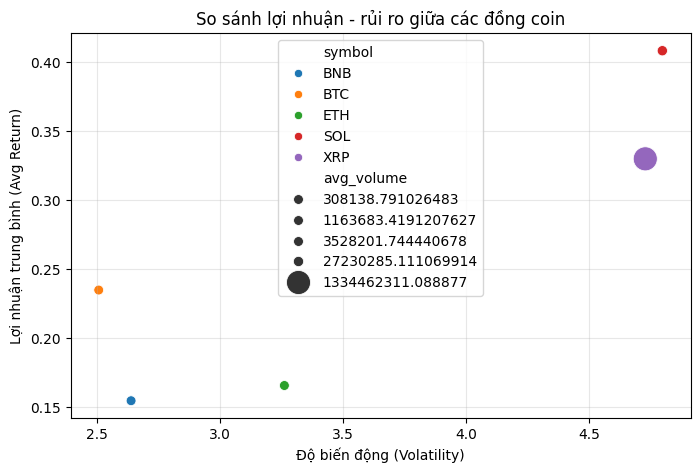


📊 So sánh chỉ số trung bình giữa các coin:
  symbol  avg_return  volatility    avg_volume  avg_price
0    BNB       0.155       2.639  1.163683e+06    460.226
1    BTC       0.235       2.507  3.081388e+05  59043.039
2    ETH       0.166       3.261  3.528202e+06   2450.146
3    SOL       0.408       4.797  2.723029e+07    108.763
4    XRP       0.330       4.728  1.334462e+09      1.037

🟢 BTC là đồng ổn định nhất trong nhóm (volatility thấp nhất).


In [110]:
# --- 1. Đọc dữ liệu ---
df = pd.read_csv("data/dataset_total_clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['symbol', 'Date'], inplace=True)

# --- 2. Kiểm tra cột cần thiết ---
required_cols = ['symbol', 'Volume', 'Close', 'pct_change']
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"⚠️ Thiếu cột '{col}' trong dataset!")

# --- 3. Tính độ biến động (volatility) và trung bình khối lượng cho từng coin ---
coin_stats = df.groupby('symbol').agg({
    'pct_change': ['mean', 'std'],
    'Volume': 'mean',
    'Close': 'mean'
}).reset_index()

coin_stats.columns = ['symbol', 'avg_return', 'volatility', 'avg_volume', 'avg_price']

# --- 4. Chuẩn hóa dữ liệu để so sánh (đưa về cùng thang) ---
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
coin_stats[['avg_return_scaled', 'volatility_scaled', 'avg_volume_scaled']] = scaler.fit_transform(
    coin_stats[['avg_return', 'volatility', 'avg_volume']]
)

# --- 5. Biểu đồ radar (so sánh trực quan 3 tiêu chí) ---
import numpy as np

def plot_radar(df_stats, coin_list=None):
    if coin_list is None:
        coin_list = df_stats['symbol'].unique()
    metrics = ['avg_return_scaled', 'volatility_scaled', 'avg_volume_scaled']
    labels = ['Lợi nhuận TB', 'Độ biến động', 'Khối lượng TB']
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    plt.figure(figsize=(7,7))
    for coin in coin_list:
        values = df_stats[df_stats['symbol'] == coin][metrics].values.flatten().tolist()
        values += values[:1]
        plt.polar(angles, values, label=coin, linewidth=2)
    
    plt.title("So sánh các đồng coin theo 3 tiêu chí")
    plt.xticks(angles[:-1], labels)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

plot_radar(coin_stats, coin_list=['BTC','ETH','BNB'] if 'ETH' in df['symbol'].unique() else ['BTC'])

# --- 6. Biểu đồ scatter giữa volatility và avg_return ---
plt.figure(figsize=(8,5))
sns.scatterplot(data=coin_stats, x='volatility', y='avg_return', size='avg_volume', hue='symbol', sizes=(50,300))
plt.title("So sánh lợi nhuận - rủi ro giữa các đồng coin")
plt.xlabel("Độ biến động (Volatility)")
plt.ylabel("Lợi nhuận trung bình (Avg Return)")
plt.grid(alpha=0.3)
plt.show()

# --- 7. In bảng kết quả ---
print("\n📊 So sánh chỉ số trung bình giữa các coin:")
print(coin_stats[['symbol','avg_return','volatility','avg_volume','avg_price']].round(3))

# --- 8. Kết luận định tính ---
btc = coin_stats[coin_stats['symbol'] == 'BTC']
if not btc.empty:
    btc_vol = btc['volatility'].values[0]
    lower_vol_coins = coin_stats[coin_stats['volatility'] < btc_vol]['symbol'].tolist()
    if lower_vol_coins:
        print(f"\n📉 BTC có độ biến động cao hơn {lower_vol_coins}")
    else:
        print("\n🟢 BTC là đồng ổn định nhất trong nhóm (volatility thấp nhất).")


---

# Data Visualization

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pywaffle import Waffle
import os


In [125]:
# setup
df['Date'] = pd.to_datetime(df['Date'])
df['Return'] = df.groupby('symbol')['Close'].pct_change()

# --- Setup style ---
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 5)

os.makedirs("data/pic", exist_ok=True)
for sym in df['symbol'].unique():
    os.makedirs(f"data/{sym}/pic", exist_ok=True)

Waffle Chart (biểu đồ bánh waffle) là cách trực quan hóa phần trăm hoặc tỷ lệ — mỗi ô vuông đại diện cho 1% tổng thể.
Khi bạn đặt tổng cộng 100 ô (10 hàng × 10 cột),
→ tức là toàn bộ hình vuông = 100% tổng khối lượng giao dịch.

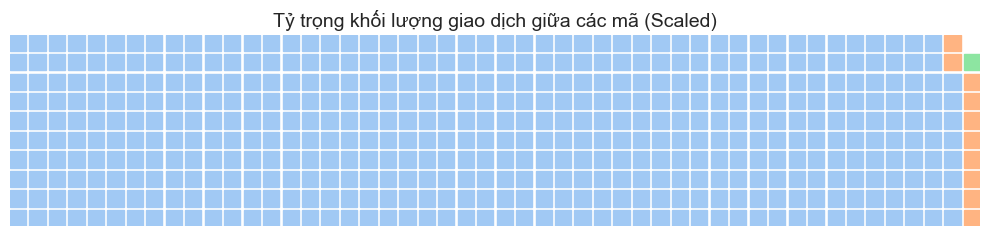

In [135]:
# WAFFLE CHART — tổng khối lượng (scaled version)
symbol_share = df.groupby('symbol')['Volume'].sum().sort_values(ascending=False)

# Chuẩn hóa tổng số ô = 100
scaled_share = (symbol_share / symbol_share.sum() * 500).round().astype(int)

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=scaled_share,
    title={'label': 'Tỷ trọng khối lượng giao dịch giữa các mã (Scaled)', 'loc': 'center', 'fontsize': 14},
    colors=sns.color_palette('pastel', n_colors=len(scaled_share)),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.savefig("data/pic/waffle_volume_share.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()


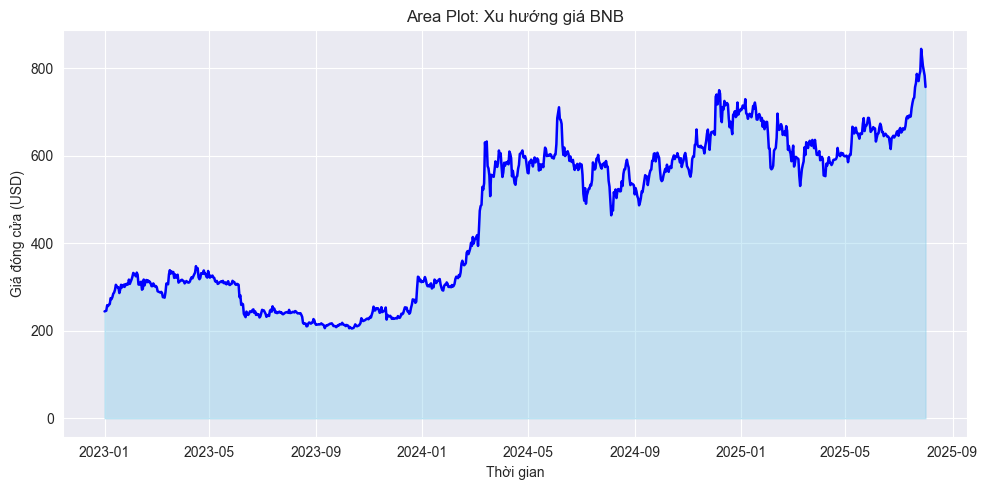

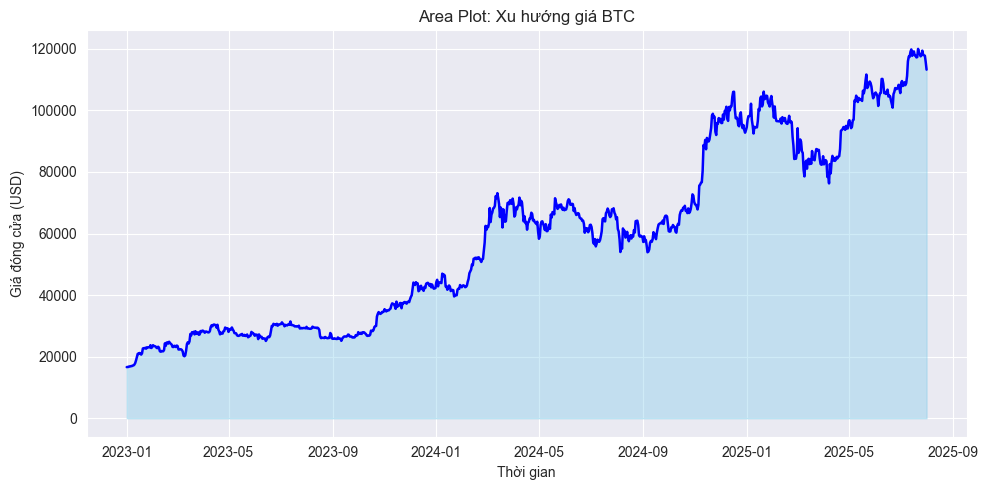

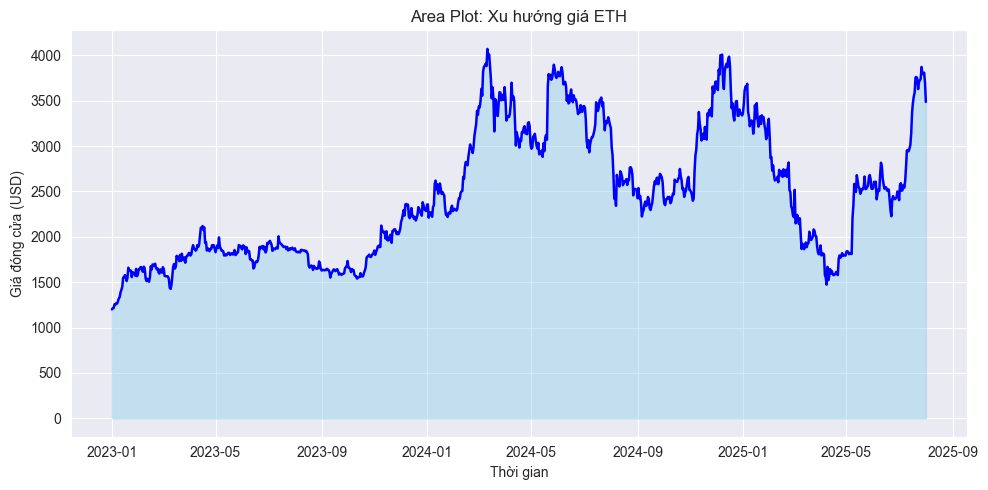

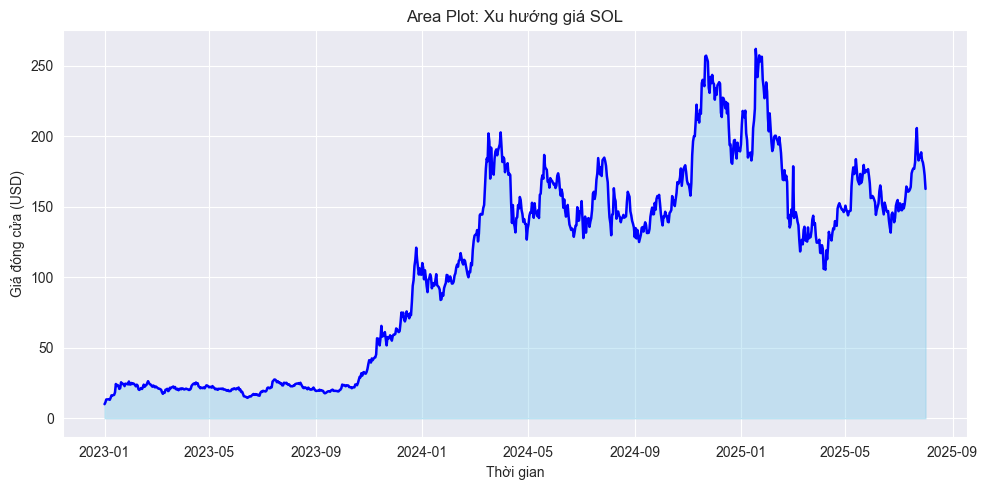

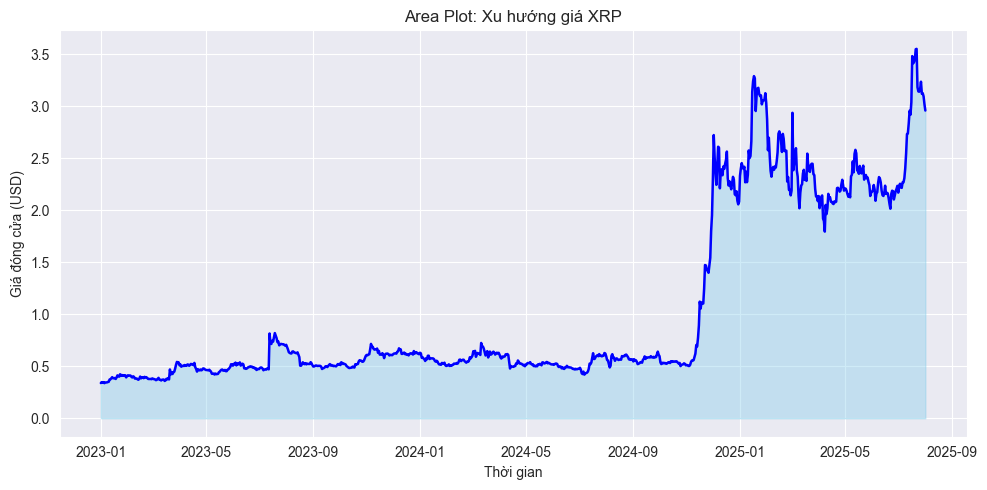

In [137]:

# AREA PLOT — mỗi mã riêng

for sym in df['symbol'].unique():
    sub = df[df['symbol'] == sym]
    plt.figure()
    plt.fill_between(sub['Date'], sub['Close'], color='skyblue', alpha=0.4)
    plt.plot(sub['Date'], sub['Close'], color='blue', linewidth=1.8)
    plt.title(f"Area Plot: Xu hướng giá {sym}")
    plt.xlabel("Thời gian")
    plt.ylabel("Giá đóng cửa (USD)")
    plt.tight_layout()
    plt.savefig(f"data/{sym}/pic/area_close_{sym}.png", dpi=300)
    plt.show()

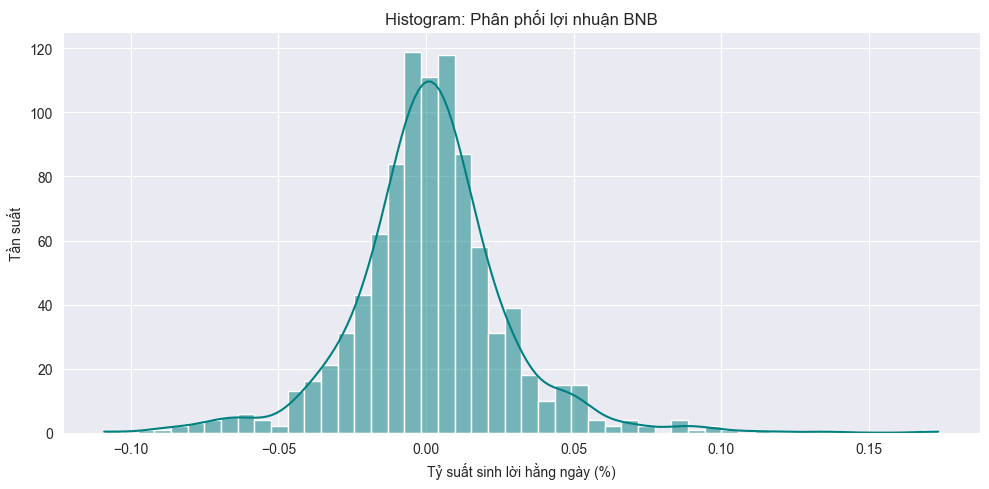

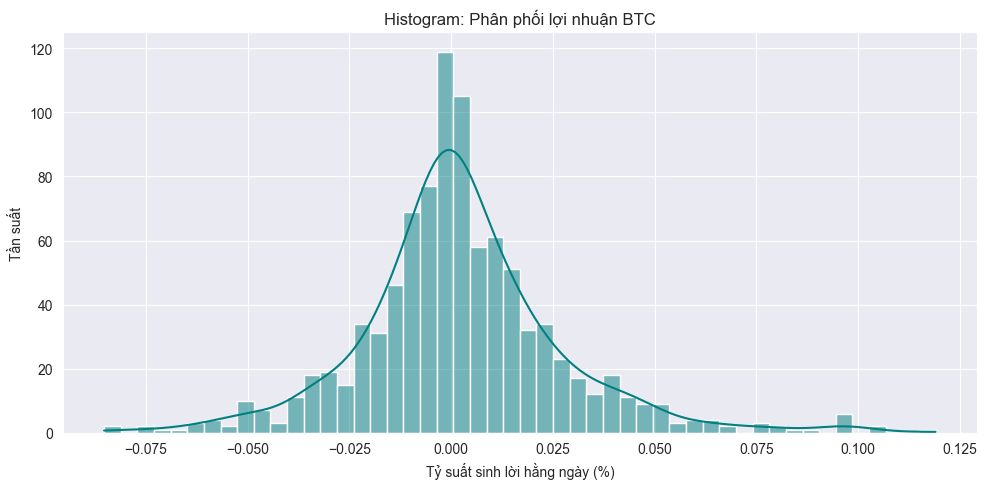

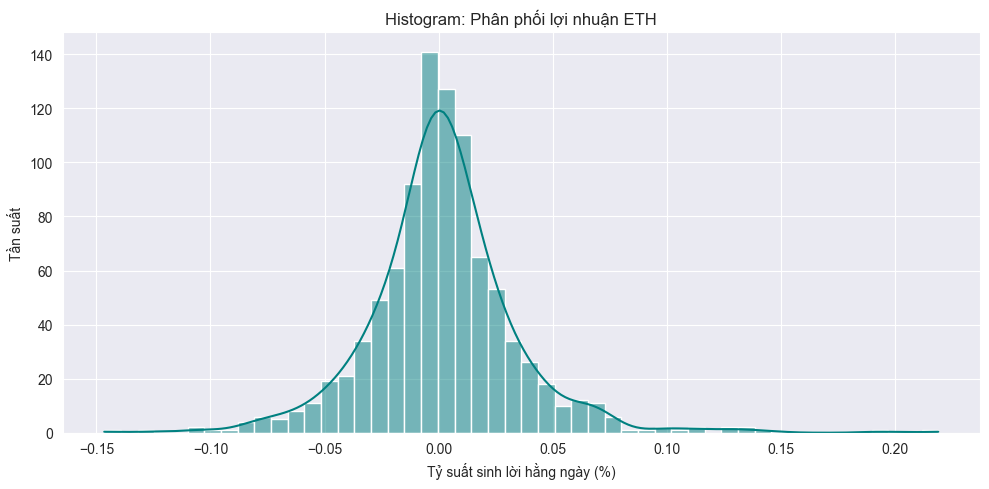

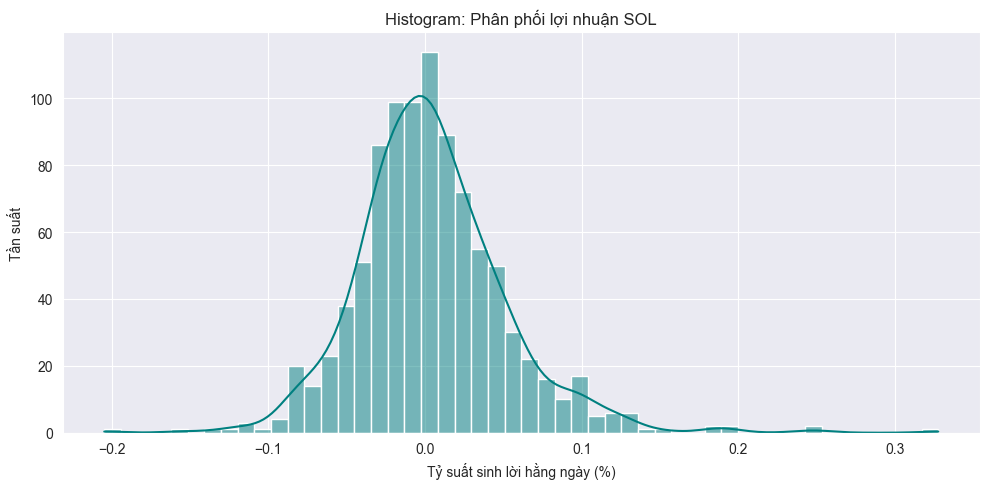

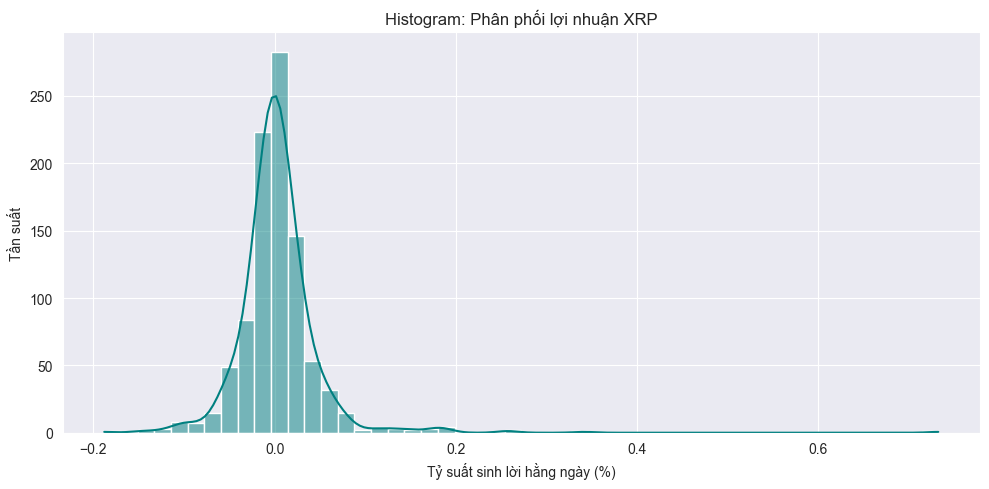

In [138]:
# =====================================================
# 📊 3️⃣ HISTOGRAM — phân phối lợi nhuận
# =====================================================
for sym in df['symbol'].unique():
    sub = df[df['symbol'] == sym]
    plt.figure()
    sns.histplot(sub['Return'], bins=50, kde=True, color='teal')
    plt.title(f"Histogram: Phân phối lợi nhuận {sym}")
    plt.xlabel("Tỷ suất sinh lời hằng ngày (%)")
    plt.ylabel("Tần suất")
    plt.tight_layout()
    plt.savefig(f"data/{sym}/pic/hist_return_{sym}.png", dpi=300)
    plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9468\1626029309.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_vol.index, y=avg_vol.values, palette='viridis')


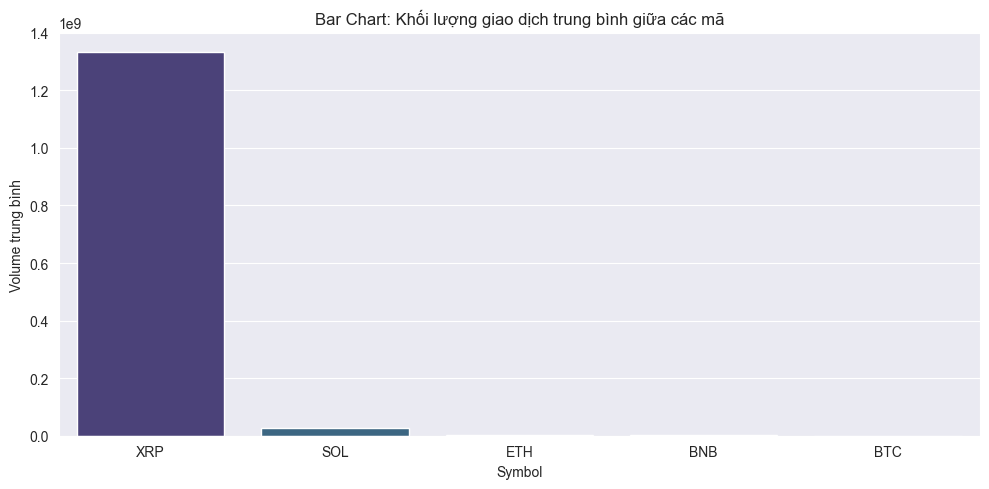

In [139]:
# =====================================================
# 📈 4️⃣ BAR CHART — tất cả symbol
# =====================================================
avg_vol = df.groupby('symbol')['Volume'].mean().sort_values(ascending=False)
plt.figure()
sns.barplot(x=avg_vol.index, y=avg_vol.values, palette='viridis')
plt.title("Bar Chart: Khối lượng giao dịch trung bình giữa các mã")
plt.xlabel("Symbol")
plt.ylabel("Volume trung bình")
plt.tight_layout()
plt.savefig("data/pic/bar_avg_volume.png", dpi=300)
plt.show()


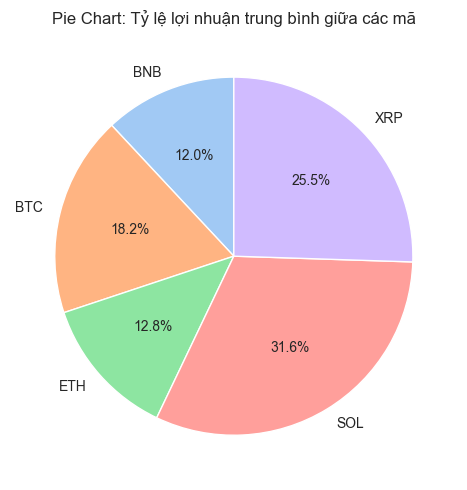

In [140]:
# =====================================================
# 🥧 5️⃣ PIE CHART — toàn bộ symbol
# =====================================================
avg_return = df.groupby('symbol')['Return'].mean()
plt.figure()
plt.pie(avg_return, labels=avg_return.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Pie Chart: Tỷ lệ lợi nhuận trung bình giữa các mã")
plt.tight_layout()
plt.savefig("data/pic/pie_avg_return.png", dpi=300)
plt.show()

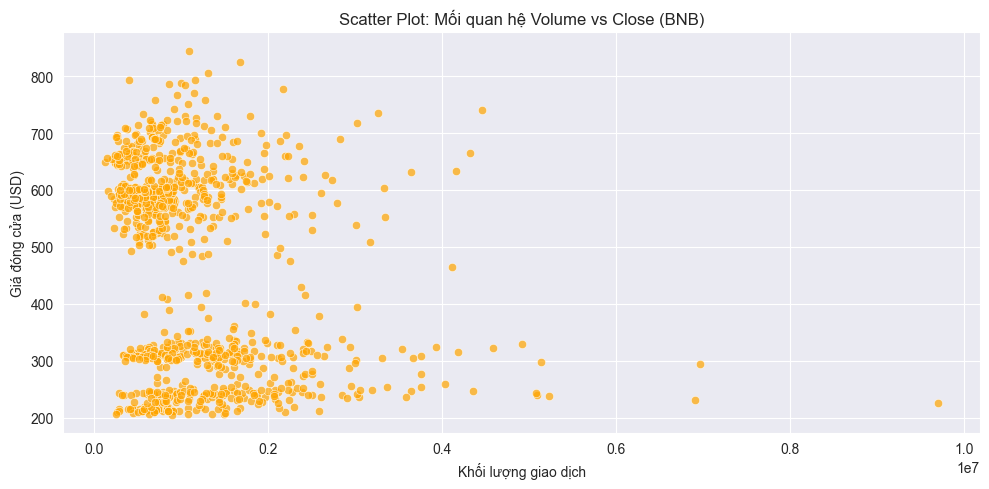

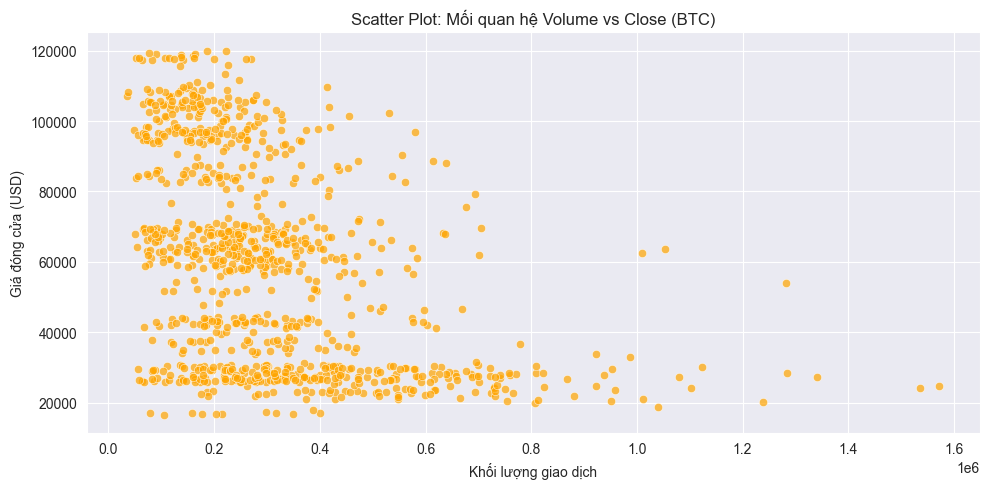

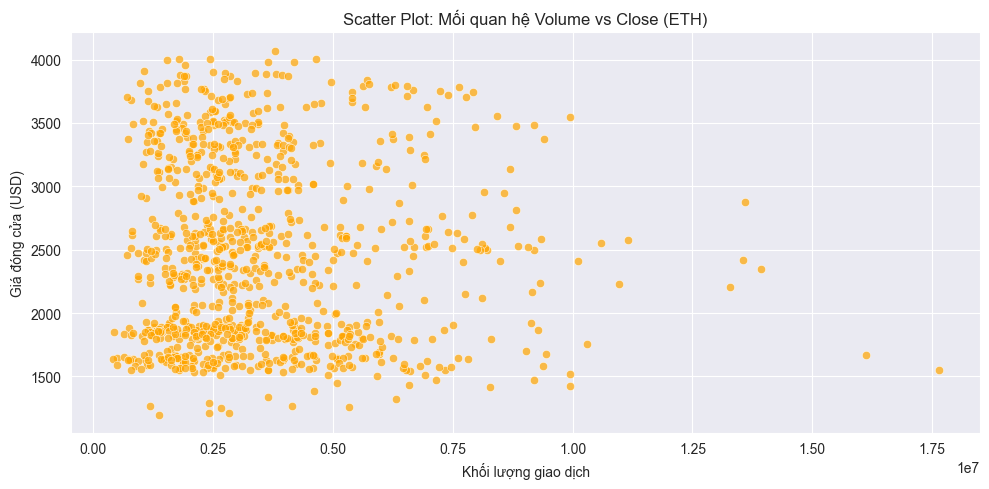

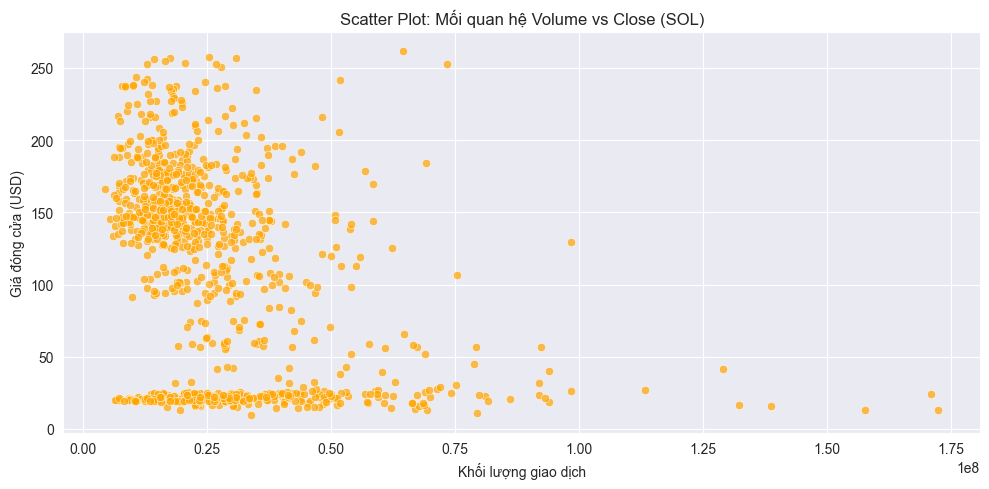

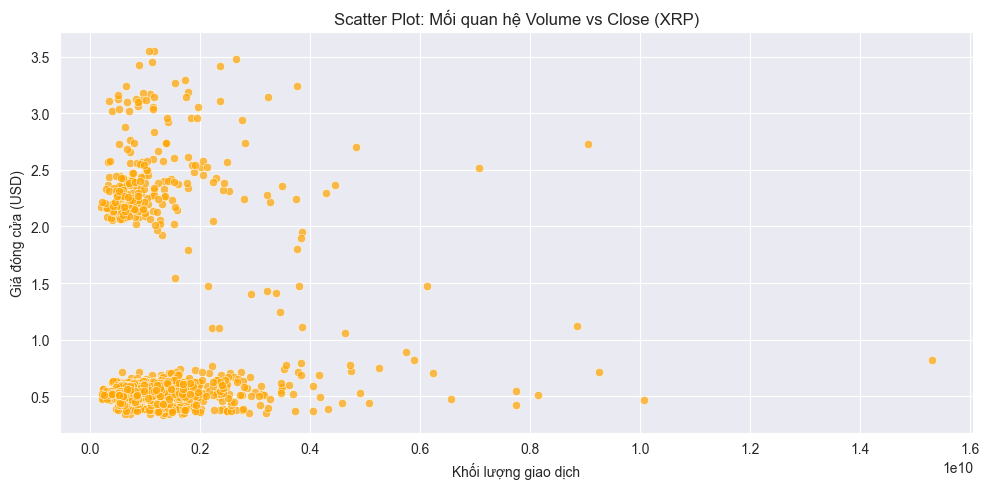

In [141]:
# =====================================================
# 💠 6️⃣ SCATTER PLOT — mỗi mã riêng
# =====================================================
for sym in df['symbol'].unique():
    sub = df[df['symbol'] == sym]
    plt.figure()
    sns.scatterplot(data=sub, x='Volume', y='Close', alpha=0.7, color='orange')
    plt.title(f"Scatter Plot: Mối quan hệ Volume vs Close ({sym})")
    plt.xlabel("Khối lượng giao dịch")
    plt.ylabel("Giá đóng cửa (USD)")
    plt.tight_layout()
    plt.savefig(f"data/{sym}/pic/scatter_vol_close_{sym}.png", dpi=300)
    plt.show()

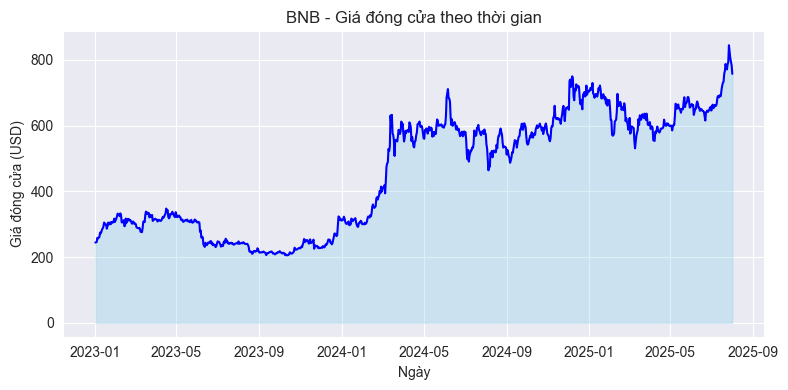

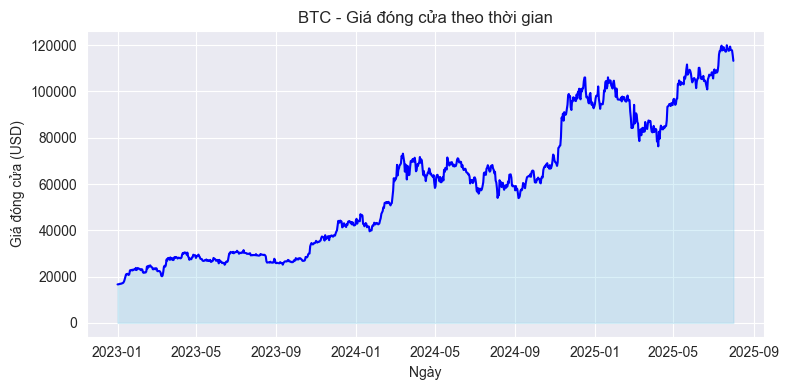

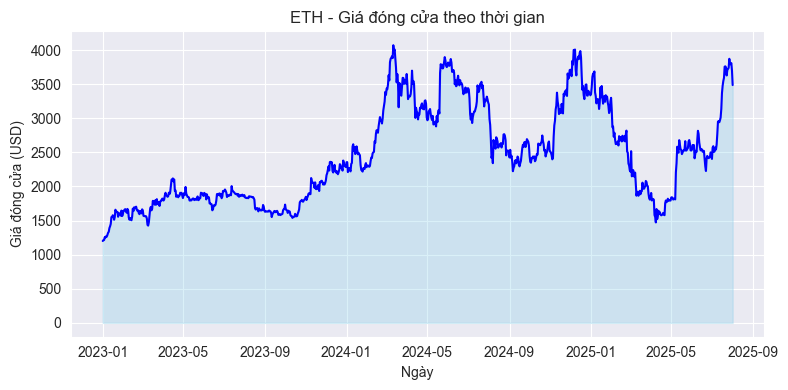

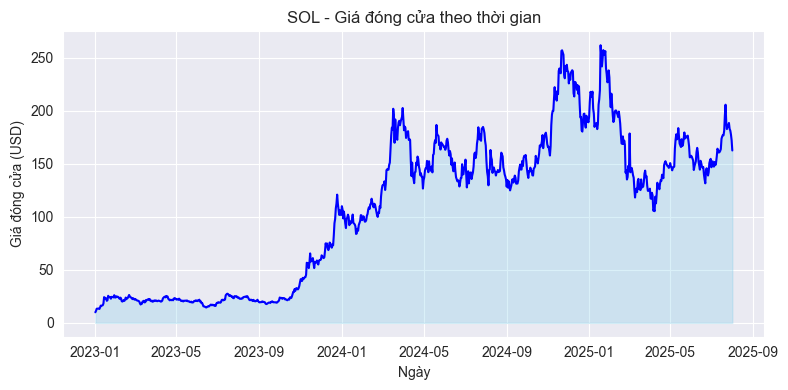

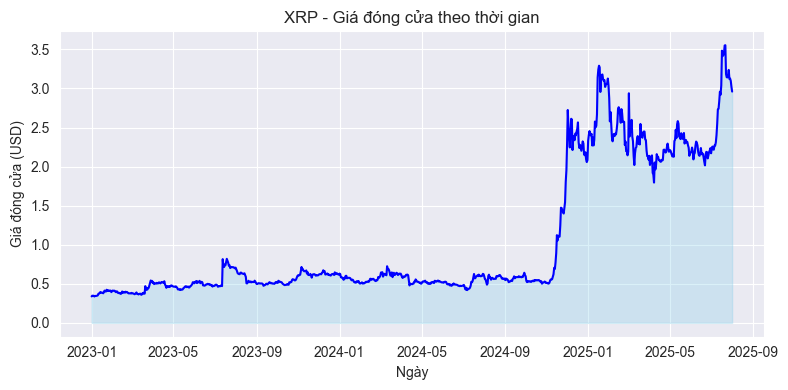

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs("data/web_pic", exist_ok=True)

for sym in df['symbol'].unique():
    sub = df[df['symbol'] == sym]
    plt.figure(figsize=(8,4))
    sns.lineplot(data=sub, x='Date', y='Close', color='blue')
    plt.fill_between(sub['Date'], sub['Close'], color='skyblue', alpha=0.3)
    plt.title(f"{sym} - Giá đóng cửa theo thời gian")
    plt.xlabel("Ngày")
    plt.ylabel("Giá đóng cửa (USD)")
    plt.tight_layout()
    plt.savefig(f"data/web_pic/{sym}_line_area.png", dpi=150)
    plt.show()
    plt.close()
